
# Neuromatch Academy: Week 3, Day 1, Tutorials
# Unsupervised and self-supervised learning: Representations

__Content creators:__ Arna Ghosh, Colleen Gillon.

__Content reviewers:__ Blake Richards, Tim Lillicrap. 

__Content editors:__ Blake Richards, Tim Lillicrap.

__Production editors:__ Blake Richards, Tim Lillicrap.  

---
#Tutorial Objectives

In this tutorial, you will learn about the importance of learning good representations of data.

Specific objectives for this tutorial:
*   Train logistic regressions (A) directly on input data and (B) on representations learned from the data.
*   Compare the classification performances achieved by the different networks.
*   Compare the representations learned by the different networks
*   Identify the advantages of self-supervised learning provides over supervised or traditional unsupervised methods.

In [1]:
#@markdown Tutorial slides

#@markdown **TO DO:** ADD LINK TO SLIDES

from IPython.display import HTML
# HTML('<iframe src="https://mfr.ca-1.osf.io/render?url=https://osf.io/kaq2x/?direct%26mode=render%26action=download%26mode=render" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup

In [2]:
#@title Download dataset, modules, and files needed for the tutorial from GitHub.

# The code is below temporary. It enables our data and code currently hosted on 
# a PRIVATE Github repo to be downloaded to the colab.
# It uses an exposed READ-ONLY deploy ssh key. 
# This is safe, as they key gives ONLY read access and ONLY to the neuromatch 
# repo. 
# Once we make the repo public, we will replace this with a simple git clone.

import os, sys, importlib

REPO_PATH = "neuromatch_ssl_tutorial"
if not os.path.exists(REPO_PATH):
    # download and place deploy key
    !mkdir -p /root/.ssh
    !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1DIL4zYLqhpEJjpsB4NQI29atFxsnvVd7' -O /root/.ssh/id_ed25519 --quiet

    # configure .ssh folder
    !touch /root/.ssh/known_hosts
    !ssh-keyscan github.com >> /root/.ssh/known_hosts 2> /dev/null # completely silenced
    !chmod 700 /root/.ssh
    !chmod 600 /root/.ssh/id_ed25519
    !chmod 644 /root/.ssh/known_hosts

download_str = "Downloading"
if os.path.exists(REPO_PATH):
    download_str = "Redownloading"
    !\rm -rf $REPO_PATH

# download from github repo
print(f"{download_str} data, modules, and files from GitHub to {REPO_PATH}...")
!ssh -Tq git@github.com 2> /dev/null # completely silenced
!git clone git@github.com:colleenjg/neuromatch_ssl_tutorial.git --quiet

from neuromatch_ssl_tutorial.modules import data, load, models, plot_util
importlib.reload(data);
importlib.reload(load);
importlib.reload(models)
importlib.reload(plot_util);

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

# import modules designed for use in these tutorials
from neuromatch_ssl_tutorial.modules import data, load, models, plot_util 

In [4]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

import warnings
warnings.filterwarnings(
    action="ignore", message="This figure includes Axes", category=UserWarning
    )
warnings.filterwarnings(
    action="ignore", message="Calculating RSM", category=UserWarning
    )

In [5]:
#@title Plotting functions

# @markdown Function to plot a histogram of RSM values: `plot_rsm_histogram(rsms, colors)`
def plot_rsm_histogram(rsms, colors, labels=None, nbins=100):
    fig, ax = plt.subplots(1)
    ax.set_title("Histogram of RSM values", y=1.05)

    min_val = np.min([np.nanmin(rsm) for rsm in rsms])
    max_val = np.max([np.nanmax(rsm) for rsm in rsms])
    
    bins = np.linspace(min_val, max_val, nbins+1)

    if labels is None:
        labels = [labels] * len(rsms)
    elif len(labels) != len(rsms):
        raise ValueError("If providing labels, must provide as many as RSMs.")

    if len(rsms) != len(colors):
        raise ValueError("Must provide as may colors as RSMs.")

    for r, rsm in enumerate(rsms):
        ax.hist(
            rsm.reshape(-1), bins, density=True, alpha=0.6, 
            color=colors[r], label=labels[r]
            )
    ax.axvline(x=0, ls="dashed", alpha=0.6, color="k")
    ax.set_ylabel("Density")
    ax.set_xlabel("Similarity values")
    ax.legend()


In [6]:
#@title Helper functions

# @markdown Function to seed processes, for reproducibility: `seed_processes()`
def seed_processes(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 
    return seed

# @markdown Function to set runtime device: `set_device()`
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, select 'GPU' under Runtime -> "
          "Change runtime type.")

# @markdown Function to set test custom torch RSM function: `test_custom_torch_RSM_fct()`
def test_custom_torch_RSM_fct(custom_torch_RSM_fct):
    rand_feats = torch.rand(100, 1000)
    RSM_custom = custom_torch_RSM_fct(rand_feats)
    RSM_ground_truth = data.calculate_torch_RSM(rand_feats)
    
    if torch.allclose(RSM_custom, RSM_ground_truth, equal_nan=True):
        print("custom_torch_RSM_fct() is correctly implemented.")
    else:
        print("custom_torch_RSM_fct() is NOT correctly implemented.")

# @markdown Function to set test custom contrastive loss function: `test_custom_contrastive_loss_fct()`
def test_custom_contrastive_loss_fct(custom_simclr_contrastive_loss):
    rand_proj_feat1 = torch.rand(100, 1000)
    rand_proj_feat2 = torch.rand(100, 1000)
    loss_custom = custom_simclr_contrastive_loss(rand_proj_feat1, rand_proj_feat2)
    loss_ground_truth = models.contrastiveLoss(rand_proj_feat1,rand_proj_feat2)
    
    if torch.allclose(loss_custom, loss_ground_truth):
        print("custom_simclr_contrastive_loss() is correctly implemented.")
    else:
        print("custom_simclr_contrastive_loss() is NOT correctly implemented.")

In [7]:
# Set global variables
SEED = 2021
DEVICE = set_device()
REPO_PATH = "neuromatch_ssl_tutorial"

---

# Section 1: Representations are important.

### **To do:** Add video

### **To do:** Add description

## Section 1.1: Introducing the dSprites dataset

In this tutorial, we will be using a subset of the openly available **dSprites dataset** to investigate the importance of learning good representations.  

_N.B.: For convenience, we will be using a subset of the original, full dataset which is available [here](https://github.com/deepmind/dsprites-dataset/), on GitHub._

In [8]:
dSprites = data.dSpritesDataset(
    os.path.join(REPO_PATH, "dsprites", "dsprites_subset.npz")
    )

### Interactive Demo 1.1.1: Exploring the dSprites dataset

In this first demo, we will get to know the **dSprites dataset**. This dataset is made up of black and white images (20,000 images total in the subset we are using).  

The images in the dataset were can be described using different combinations of **latent dimension values**, sampled from:
- **Shapes (3):** square (1.0), oval (2.0) or heart (3.0)
- **Scales (6):** 0.5 to 1.0
- **Orientations (40):** 0 to 2$\pi$
- **Positions in X (32):** 0 to 1 (left to right)
- **Positions in Y (32):** 0 to 1 (top to bottom)

As a result, **each image carries 5 labels.** One for each of the latent dimension.  

We will first load the dataset into the `dSprites` object, which is an instance of the `data.dSpritesDataset` class.


Next, we use the `dSpritesDataset` class method `show_images()` to plot a few images from the dataset, with their latent dimension values printed below.    

**Interactive Demo:** View a different set of randomly sampled images by passing the random state argument `randst` any integer or the value `None`. (The original setting is `randst=SEED`.)

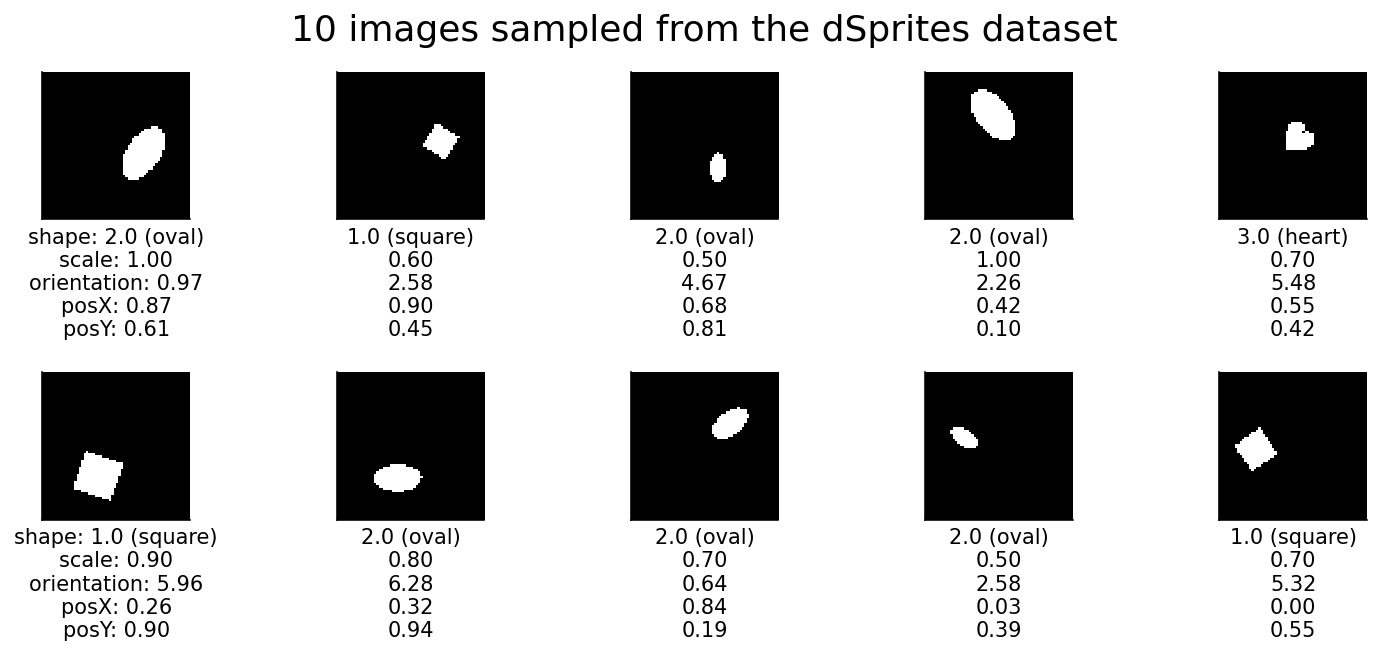

In [9]:
# DEMO: to view different images, set randst to any integer value.
dSprites.show_images(num_images=10, randst=SEED)

## Section 1.2: Training a classifier with and without representations  

Now, we will investigate how 2 different types of classifiers perform when trained to decode the shape latent dimension of images in the **dSprites dataset**.  

Specifically, we will train **one classifier directly on the images**, and **another on the output of an encoder network**.

The **encoder network** we will use here and throughout the tutorial is the multi-layer convolutional network, pictured below. It comprises 2 consecutive convolutional layers, followed by 3 fully connected layers, and uses average pooling and batch normalization between layers, as well as rectified linear units as non-linearities. 

The **classifier layer** then takes the encoder features as input, predicting, for example, the shape latent dimension of encoded input images.

![](https://drive.google.com/uc?id=1ZlKeDK7cD-3aNV8EbC0XOQr8yuQvBuGd)

### Interactive Demo 1.2.1: Training a logistic regression classifier directly on images.

The following code:
*    seeds modules that will use random processes, to ensure the results are consistently reproducible, using the `seed_processes()` function,
*    collects the dSprites dataset into a torch dataset using the `data.dSpritesTorchDataset` class, 
*    initializes a training and test sampler to keep the two datasets separate using the `data.train_test_splix_idx()` function.

_(cont'd below)_

In [10]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# initialize a torch dataset, specifying the target latent dimension for 
# the classifier
dSprites_torchdataset = data.dSpritesTorchDataset(
    dSprites, 
    target_latent="shape"
    )

# initialize a train_sampler and a test_sampler to keep the two sets 
# consistently separate
train_sampler, test_sampler = data.train_test_split_idx(
    dSprites_torchdataset, 
    fraction_train=0.8, # 80:20 data split
    randst=SEED
    )

print(f"Dataset size: {len(train_sampler)} training, "
  f"{len(test_sampler)} test images")

Dataset size: 16000 training, 4000 test images


### Interactive Demo 1.2.1: Training a logistic regression classifier directly on images (cont'd).

The following code:
*    trains a logistic regression directly on the training set images to classify their shape, and assesses its performance on the test set images using the `models.train_classifier()` function.

**Interactive Demo:** Try a few different `num_epochs` settings to see whether performance improves with more training, e.g., between 1 and 50 epochs. (The original setting is `num_epochs=25`.)

In [11]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

num_epochs = 25 # DEMO: Try different numbers of training epochs

# train a classifier directly on the images
print("Training a classifier directly on the images...")
_ = models.train_classifier(
    encoder=None, 
    dataset=dSprites_torchdataset, 
    train_sampler=train_sampler, 
    test_sampler=test_sampler, 
    freeze_features=True, # there is no feature encoder to train here, anyway
    num_epochs=num_epochs, 
    verbose=True # print results
    )

Training a classifier directly on the images...



Network performance after 25 classifier training epochs (chance: 33.33%):
    Training accuracy: 51.81%
    Testing accuracy: 39.55%


As we can observe, the classifier trained directly on the images performs only a bit above chance (39.55%) on the test set, after 25 training epochs.

### Coding Exercise 1.2.1: Training a logistic regression classifier along with an encoder.

The following code:
*    uses the same dSprites torch dataset (`dSprites_torchdataset`) initialized above, as well as the training and test samplers (`train_sampler`, `test_sampler`),
*    again, seeds modules that will use random processes, to ensure the results are consistently reproducible,
*    initializes an encoder network to use in the supervised network using the `models.EncoderCore` class,
*    sets a proposed number of epochs to use when training the classifier and encoder (`num_epochs=10`). 

**Exercise:** Train a classifier, along with the encoder, to classify the input images according to shape, using `models.train_classifier()`. How does it perform?

**Hint**: `models.train_classifier()` is introduced in **Interactive Demo 1.2.1**.

In [12]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# initialize a core encoder network on which the classifier will be added
supervised_encoder = models.EncoderCore()

num_epochs = 10 # Proposed number of training epochs


#################################################
# EXERCISE: Train an encoder and classifier on the images, using models.train_classifier()
print("Training a supervised encoder and classifier...")
raise NotImplementedError("Exercise: Train a supervised encoder and classifier.")
#################################################

Training a supervised encoder and classifier...


NotImplementedError: ignored

In [ ]:
# @markdown ### Solution 1.2.1

# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# initialize a core encoder network on which the classifier will be added
supervised_encoder = models.EncoderCore()

num_epochs = 10

# EXERCISE: Train an encoder and classifier on the images, using models.train_classifier()
print("Training a supervised encoder and classifier...")
_ = models.train_classifier(
    encoder=supervised_encoder, 
    dataset=dSprites_torchdataset, 
    train_sampler=train_sampler, 
    test_sampler=test_sampler, 
    freeze_features=False, # we train the encoder, along with the classifier layer
    num_epochs=num_epochs, 
    verbose=True # print results
    )

When the classifier is trained with an encoder network, however, it achieves very high classification accuracy (98.40%) on the test set, after only 10 training epochs.

---

# Section 2: Supervised learning induces invariant representations.


### **To do:** Add video

### **To do:** Add description

## Section 2.1: Examining Representational Similarity Matrices (RSMs)

To examine the representations learned by the encoder network, we use **Representational Similarity Matrices (RSMs)**. In these matrices, the similarity between the encoder's representations of each possible pair of images is plotted to reveal overall structure in representation space.  

_N.B.: Here, we use cosine similarity as a measure of representational similarity._


### Coding Exercise 2.1.1: Complete a function that calculates RSMs.

The following code:
*    lays out the skeleton of a function `custom_torch_fct()` which calculates an RSM from features,
*    tests the custom function against the solution implementation.

**Exercise:** Complete the `custom_torch_fct()` implementation.

**Hint**: `custom_torch_fct()` takes 1 input argument: 
- features (2D torch Tensor): feature matrix (items x features)

In [ ]:
def custom_torch_RSM_fct(features):
    """
    custom_torch_RSM_fct(features)

    Custom function to calculates representational similarity matrix (RSM) of a feature 
    matrix using pairwise cosine similarity. 

    Complete the function below given the specific guidelines.
    Uses torch.nn.functional.cosine_similarity()
    
    Required args:
    - features (2D torch Tensor): feature matrix (items x features)

    Returns:
    - rsm (2D torch Tensor): similarity matrix 
        (nbr features items x nbr features items)
    """

    #################################################
    # EXERCISE: Implement RSM calculation 
    rsm = None
    raise NotImplementedError("Exercise: Implement RSM calculation.")    
    #################################################

    if not rsm.shape == (len(features), len(features)): 
        raise ValueError(
            f"RSM should be of shape ({len(features)}, {len(features)})"
            )

    return rsm


# Test implementation by comparing output to solution implementation
test_custom_torch_RSM_fct(custom_torch_RSM_fct)


In [ ]:
# @markdown ### Solution 2.1.1
def custom_torch_RSM_fct(features, mem_thr=1e5):
    """
    custom_torch_RSM_fct(features)

    Custom function to calculates representational similarity matrix (RSM) of a feature 
    matrix using pairwise cosine similarity. 
    
    Required args:
    - features (2D torch Tensor): feature matrix (items x features)

    Returns:
    - rsm (2D torch Tensor): similarity matrix 
        (nbr features items x nbr features items)
    """

    # EXERCISE: Implement RSM calculation 
    rsm = torch.nn.functional.cosine_similarity(
        features.unsqueeze(1), features.unsqueeze(0), dim=2
        )

    if not rsm.shape == (len(features), len(features)): 
        raise ValueError(
            f"RSM should be of shape ({len(features)}, {len(features)})"
            )
    
    return rsm

## Test implementation by comparing output to solution implementation
test_custom_torch_RSM_fct(custom_torch_RSM_fct)

### Interactive Demo 2.1.1: Plotting the supervised network encoder RSM along different latent dimensions.

In this demo, we calculate an RSM for representations of the test set images generated by the supervised network encoder. 

The following code:
*    calculates and plots the RSM for the test set, with rows and columns sorted by whichever latent dimension is specified (e.g., `sorting_latent="shape"`) using `models.plot_model_RSMs()`.

**Interactive Demo:** In the current example, the rows and columns of the RSM are organized by along the `shape` latent dimension. Try organizing them along one of the other latent dimensions (`"posX"`, `"posY"`, `"orientation"` or `"scale"`) to see whether different patterns emerge. (The original setting is `sorting_latent="shape"`.)

In [ ]:
sorting_latent = "shape" # DEMO: Try sorting by different latent dimensions

print("Plotting RSMs...")
_ = models.plot_model_RSMs(
    encoders=[supervised_encoder], # we pass the trained supervised_encoder
    dataset=dSprites_torchdataset, 
    sampler=test_sampler, # we want to see the representations on the held out test set
    titles=["Supervised network encoder RSM"], # plot title
    sorting_latent=sorting_latent,
    RSM_fct=custom_torch_RSM_fct
    )

### Discussion 2.1.1: What patterns do the RSMs reveal about how the encoder represents different images? 
**A.** What does the yellow (maximal similarity color) diagonal, going from the top left to the bottom right, correspond to?  
**B.** What pattern can be observed when comparing RSM values for pairs of images that share a similar latent value (e.g., 2 heart images) vs pairs of images that do not (e.g., a heart and a square image)?   
**C.** Do some shapes appear to be encoded more similarly than others?  
**D.** Do some latent dimensions show clearer RSM patterns than others? Why might that be so?

### Responses to 2.1.1
**A.** The yellow diagonal corresponds to the similarity between each encoded image and itself. Since each encoded image is, of course, identical to itself, the similarity is of 1 at each point on the diagonal.  
**B.** The pattern we observe is that there are square sections of the RSM that have higher similarity values than the rest, and these sections lie along the yellow diagonal. These sections correspond to the similarities between **encoded images of the same shape** (e.g., 2 hearts), which are generally **higher than the similarities between encoded images of different shapes** (e.g., a heart and a square), when using this trained, supervised encoder.  
**C.** It is a bit subtle, but it looks like the **hearts and squares** might be encoded more similarly to one another than the **hearts and ovals**, in general. This is based on the fact that the RSM values for hearts x squares (bottom left and top right) appear to be lighter (more yellow) than the the RSM values for hearts x ovals (bottom middle and middle right), which are a bit darker (more blue).  
**D.**  If we sort by different latent dimensions (e.g., orientation, scale, posX or posY), we do not see as much structure in the RSMs. This is because the supervised encoder is specifically trained on a shape classification task, which forces it to encode images of the same shape more similarly, and images of different shapes more differently. It is not trained to distinguish orientations, scales or positions. If it **were** trained to predict orientation, scale or position, we could expect to see similar RSM patterns, with high similarity along the diagonal for the predicted dimension. 


---

# Section 3: Random projections don’t work as well



### **To do:** Add video

### **To do:** Add description

## Section 3.1: Examining RSMs of an untrained encoder

To determine whether the patterns observed in the RSMs of the supervised network encoder are trivial, we investigate whether they also emerge from the **random projections of an untrained encoder**.

### Coding Exercise 3.1.1: Plotting an untrained network encoder RSM along different latent dimensions.

In this exercise, we repeat the same analysis as in **Section 2.1**, but with an untrained encoder.  

The following code:
*    initializes an encoder network to use in the untrained network using the `models.EncoderCore` class,
*    proposes a latent dimension along which to sort the rows and columns (`sorting_latent = "shape"`)

**Exercise:** 
*    Visualize the RSMs for the supervised and untrained network encoders, using `models.plot_model_RSMs()`. 
*    Visualize the RSMs, organized along different latent dimensions (`"posX"`, `"posY"`, `"orientation"` or `"scale"`), and compare the patterns observed for the supervised versus the untrained encoder network.

**Hint**: `models.plot_model_RSMs()` is introduced in **Interactive Demo 2.1.1**.

In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# initialize a core encoder network that will not get trained
untrained_encoder = models.EncoderCore()


#################################################
# EXERCISE: Try sorting by different latent dimensions
sorting_latent = "shape"
#################################################


#################################################
# EXERCISE: Plot RSMs
print("Plotting RSMs...")
raise NotImplementedError("Exercise: Plot RSMs.")
#################################################

In [ ]:
# @markdown ### Solution 3.1.1

# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# initialize a core encoder network that will not get trained
untrained_encoder = models.EncoderCore()

# EXERCISE: Try sorting by different latent dimensions
sorting_latent = "shape"

# EXERCISE: Plot RSMs
print("Plotting RSMs...")
_ = models.plot_model_RSMs(
    encoders=[supervised_encoder, untrained_encoder], # we pass both encoders
    dataset=dSprites_torchdataset, 
    sampler=test_sampler, # we want to see the representations on the held out test set
    titles=["Supervised network encoder RSM", "Untrained network encoder RSM"], # plot titles
    sorting_latent=sorting_latent,
    )

### Discussion 3.1.1: What does comparing these RSMs reveal about the potential value of trained versus untrained encoder representations? 

**A.** What patterns, if any, are visible in the untrained network encoder RSM?   
**B.** Which encoder network is most likely to produce meaningful representations?

### Responses to 3.1.1
**A.** Only the yellow diagnonal identity line is visible. No other patterns emerge, as most images are encoded with near 0 similarity to one another, using the untrained encoder.  
**B.** The trained, supervised network produces more meaningful representations, as the similarity between different encoded images actually **captures certain meaningful conceptual similarities between the different images**, specifically shape. In other words, the image representations obtained with the trained, supervised encoding reflect the fact that two hearts are more conceptually similar to each other in terms of shape than a heart and a square.

### Coding Exercise 3.1.2: Evaluating the classification performance of a logistic regression trained on the representations produced by an untrained network encoder.

In this exercise, we repeat a similar analysis to **Section 1.2.2**, but with the untrained encoder network. Importantly, this time, the encoder parameters must stay frozen during training by setting `freeze_features=True`. Instead of being provided ahead of time a suggestion for a reasonable number of training epochs, we use the training loss array to select a good value.  


The following code:
*    trains a logistic regression on top of the untrained encoder network to classify images based on shape, and assesses its performance on the test set images using `models.train_classifier()` with `freeze_features=True` to ensure that the encoder is **not** trained, and only the classifier is.

**Exercise:** 
*     Set a number of epochs for which  to train classifier.  
*     Plot the training loss array (`untrained_loss_array`) returned when training the model. _(N.B.: 'untrained' is in the name here simply because the classifier is trained on the ***untrained*** network encoder.)_ 
*     Rerun the classifier if more training epochs are needed based on the progression of the training loss.


In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

#################################################
# EXERCISE: Set a reasonable number of training epochs
num_epochs = None 
#################################################


# train classifier on the randomly encoded images
print("Training a classifier on the untrained encoder representations...")
_, untrained_loss_array, _, _ = models.train_classifier(
    encoder=untrained_encoder, 
    dataset=dSprites_torchdataset, 
    train_sampler=train_sampler, 
    test_sampler=test_sampler, 
    freeze_features=True, # keep the encoder frozen while training the classifier
    num_epochs=num_epochs, 
    verbose=True # print results
    )


#################################################
# EXERCISE: Plot the loss array
raise NotImplementedError("Exercise: Plot loss array.")
#################################################

In [ ]:
# @markdown ### Solution 3.1.2

# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# EXERCISE: Set a reasonable number of training epochs
num_epochs = 25

# train classifier on the randomly encoded images
print("Training a classifier on the untrained encoder representations...")
_, untrained_loss_array, _, _ = models.train_classifier(
    encoder=untrained_encoder, 
    dataset=dSprites_torchdataset, 
    train_sampler=train_sampler, 
    test_sampler=test_sampler, 
    freeze_features=True, # keep the encoder frozen while training the classifier
    num_epochs=num_epochs, 
    verbose=True # print results
    )

# EXERCISE: Plot the loss array
fig, ax = plt.subplots()
ax.plot(untrained_loss_array)
ax.set_title("Loss of classifier trained on an untrained encoder.")
ax.set_xlabel("Epoch number")
_ = ax.set_ylabel("Training loss")

The network loss training start is fairly stable by 25 epochs, at which point the classifier performs at 44.67% accuracy on the test dataset. 

### Discussion 3.1.2: What can we conclude about the potential consequences of using random projections with a dataset like dSprites? 

**A.** How does the classifier performance compare to (A) the classifier trained directly on the images and (B) the classifier trained along with the encoder?   
**B.** What explains these different performances?

### Responses 3.1.2
**A.**  
**B.**  

---

# Section 4: Generative approaches to representation learning can fail.


### **To do:** Add video

### **To do:** Add description

## Section 4.1: Examining the RSMs of a Variational Autoencoder

We next ask what kind of representations a network can learn in the absence of labelled data. We first look at a **generative model**, namely the **Variational Autoencoder (VAE)**.  

Given that generative models typically require more training than supervised models, instead of pre-training a network here, we will load one that was **pre-trained for 300 epochs**. Importantly, the **encoder shares the same architecture** as the one used for the supervised and untrained examples above.

The following code:
*    loads the parameters of a full VAE network (encoder and decoder) pre-trained on the generative task of reconstructing the input images, under the Kullback–Leibler divergence (KLD) minimization constraint over the latent space that characterizes VAEs, using `load.load_encoder()` and `load.load_decoder()`, 

In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# Load VAE encoder and decoder pre-trained on the reconstruction and KLD tasks
vae_encoder = load.load_encoder(REPO_PATH, model_type="vae")
vae_decoder = load.load_vae_decoder(REPO_PATH)

### Interactive Demo 4.1.1: Plotting example reconstructions using the pre-trained VAE encoder and decoder.

In this demo, we sample images from the test set, and take a look at the quality of the reconstructions using `models.plot_vae_reconstructions()`.  

**Interactive Demo:** Try plotting different images from the test dataset by selecting different `test_sampler.indices` values. (Original setting is `indices=test_sampler.indices[:10]`.)

In [ ]:
models.plot_vae_reconstructions(
    vae_encoder, # pre-trained encoder
    vae_decoder, # pre-trained decoder
    dataset=dSprites_torchdataset, 
    indices=test_sampler.indices[:10], # DEMO: select different indices to plot from the test set 
    title="VAE test set image reconstructions", 
    )

### Discussion 4.1.1: How does the VAE perform on the reconstruction task? 
*    Which latent features does the network appear to encode well, and which does it encode less well?

_N.B.: This VAE network uses a basic VAE loss with a convolutional encoder (our core encoder network), and a deconvolutional decoder. This can lead to some blurriness in the reconstructed shapes which a more sophisticated VAE could overcome._

### Coding Exercise 4.1.1: Evaluating the RSMs produced by the VAE encoder network.

We will now compare the pre-trained VAE encoder network RSM to the previously generated encoder RSMs. 

**Exercise:** 
*    Visualize the RSMs for the supervised, untrained and VAE network encoders, using `models.plot_model_RSMs()`. 
*    Visualize the RSMs, organized along different latent dimensions (`"posX"`, `"posY"`, `"orientation"` or `"scale"`), and compare the patterns observed for the different encoder networks.

**Hint**: `models.plot_model_RSMs()` is introduced in **Interactive Demo 2.1.1**.

In [ ]:
#################################################
# EXERCISE: Visualize RSMs for the supervised, untrained and VAE network encoders.
raise NotImplementedError("Exercise: Plot RSMs.")
#################################################

In [ ]:
# @markdown ### Solution 4.1.1

# EXERCISE: Visualize RSMs for the supervised, untrained and VAE network encoders.
sorting_latent = "shape"

print("Plotting RSMs...")
_ = models.plot_model_RSMs(
    encoders=[supervised_encoder, untrained_encoder, vae_encoder], # we pass all three encoders
    dataset=dSprites_torchdataset, 
    sampler=test_sampler, # we want to see the representations on the held out test set
    titles=["Supervised network encoder RSM", "Untrained network encoder RSM", 
            "VAE network encoder RSM"], # plot titles
    sorting_latent=sorting_latent,
    )

### Discussion 4.1.2: What can we conclude about the the ability of generative models like VAEs to construct a meaningful representation space?

**A.** How do the pre-trained VAE encoder RSMs (sorted along different latent dimensions) compare to the supervised and untrained encoder network RSMs?  
**B.** What explains these different RSMs?  
**C.** How well will the pre-trained VAE encoder likely perform on the shape classification task, as compared to the other encoder networks?  
**D.** Might the pre-trained VAE encoder be better suited to predicting a different latent dimension?

### Responses 4.1.2
**A.**  
**B.**  
**C.**  
**D.**  

### Coding Exercise 4.1.2: Evaluating the classification performance of a logistic regression trained on the representations produced by the pre-trained VAE network encoder.

For the pre-trained VAE encoder, as the encoder parameters have already been trained, they should be kept frozen while the classifier is trained by setting `freeze_features=True`.   

**Exercise:** 
*     Set a number of epochs for which  to train classifier.  
*     Train a classifier, along with the encoder, to classify the input images according to shape, using `models.train_classifier()`.
*     Plot the loss array returned when training the model, and update the number of training epochs, if needed. 

**Hint**: `models.train_classifier()` is introduced in **Interactive Demo 1.2.1**.

In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

#################################################
# EXERCISE: Set a reasonable number of training epochs
num_epochs = None
#################################################


#################################################
# EXERCISE: Train an encoder and classifier on the images, using models.train_classifier()
print("Training a classifier on the pre-trained VAE encoder representations...")
raise NotImplementedError("Exercise: Train a classifer on the pre-trained VAE encoder representations.")
#################################################


#################################################
# EXERCISE: Plot the VAE classifier training loss.
raise NotImplementedError("Exercise: Plot the VAE classifier training loss.")
#################################################

In [ ]:
# @markdown ### Solution 4.1.2 

# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# EXERCISE: Set a reasonable number of training epochs
num_epochs = 25

# EXERCISE: Train an encoder and classifier on the images, using models.train_classifier()
print("Training a classifier on the pre-trained VAE encoder representations...")
_, vae_loss_array, _, _ = models.train_classifier(
    encoder=vae_encoder, 
    dataset=dSprites_torchdataset, 
    train_sampler=train_sampler, 
    test_sampler=test_sampler, 
    freeze_features=True, # keep the encoder frozen while training the classifier
    num_epochs=num_epochs, 
    verbose=True # print results
    )

# EXERCISE: Plot the VAE classifier training loss.
fig, ax = plt.subplots()
ax.plot(vae_loss_array)
ax.set_title("Loss of classifier trained on a VAE encoder.")
ax.set_xlabel("Epoch number")
_ = ax.set_ylabel("Training loss")

The network loss training is fairly stable by 25 epochs, at which point the classifier performs at 45.75% accuracy on the test dataset.  

---

# Section 5: The modern approach to self-supervised training for invariance.

### **To do:** Add video

### **To do:** Add description

## Section 5.1: Examining different options for learning invariant representations.

We now take a look at a few options for learning invariant shape representations for a dataset such as dSprites.  

### Interactive Demo 5.1.1: Visualizing a few different image transformations available that could be used to learn invariance.

The following code:
*    initializes a set of transforms called `invariance_transforms` using the `torchvision.transforms.RandomAffine` class,
*    collects the dSprites dataset into a torch dataset `dSprites_invariance_torchdataset` which takes the `invariance_transforms` as input and deploys the transforms when it is called, 
*    shows a few examples of images and their transformed versions using the `data.dSpritesTorchDataset` `show_images()` method. 

The `torchvision.transforms.RandomAffine` class enables us to predetermine which types and ranges of transforms will be sampled from when transforming the images, by setting the following arguments:
*    `degrees`: absolute maximum number of degrees to rotate
*    `translate`: absolute maximum proportion of width to shift in x, and of height to shift in y
*   `scale`: minimum to maximum scaling factor

**Interactive Demo:** Try out a few combinations of the transformation parameters, and visualize the resulting effects on the original images. (The original settings are `degrees=90`, `translate=(0.2, 0.2)`, `scale=(0.8, 1.2)`.) 

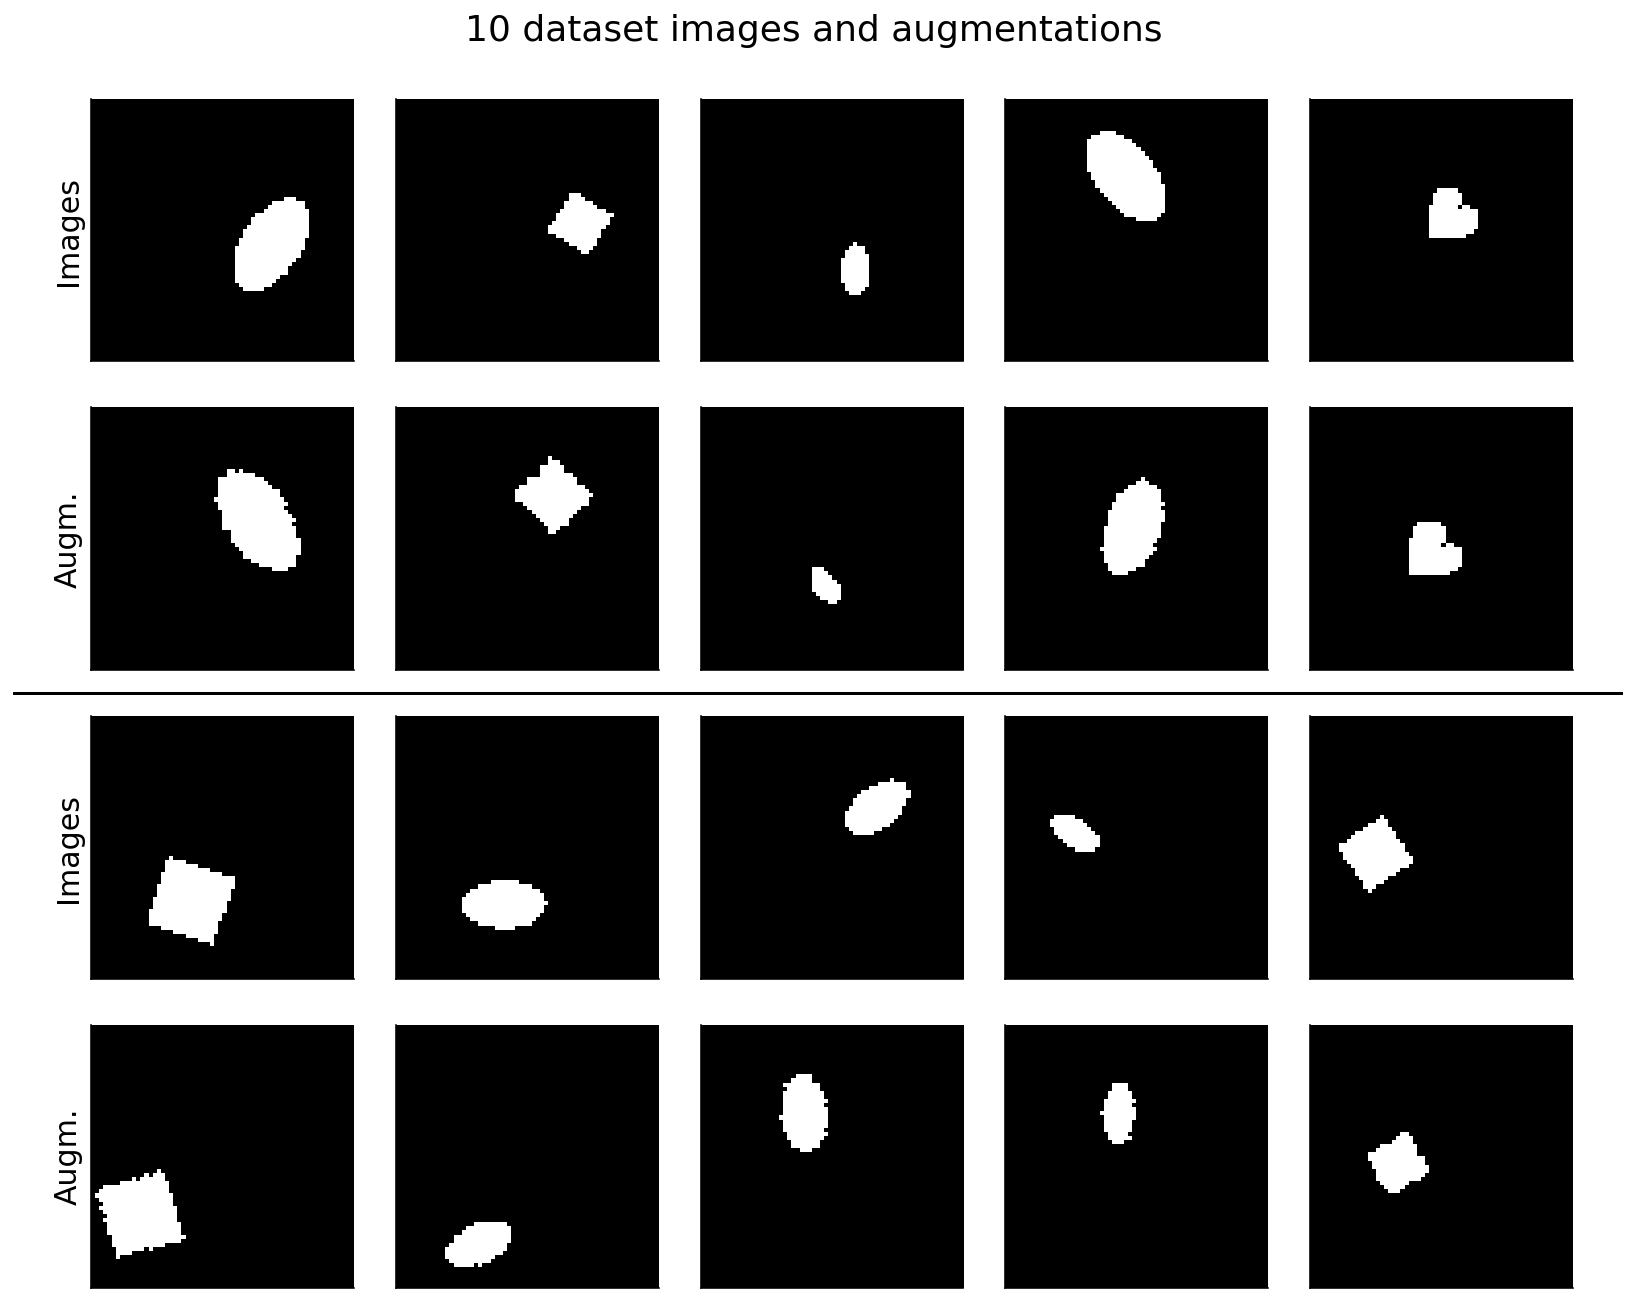

In [13]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# DEMO: Try some random affine data augmentations combinations to apply to the images
invariance_transforms = torchvision.transforms.RandomAffine(
    degrees=90, 
    translate=(0.2, 0.2), # (in x, in y)
    scale=(0.8, 1.2) # min to max scaling
)

# initialize a simclr-specific torch dataset 
dSprites_invariance_torchdataset = data.dSpritesTorchDataset(
    dSprites, 
    target_latent="shape", 
    simclr=True, 
    simclr_transforms=invariance_transforms
    )

# show a few example images are their augmentations
_ = dSprites_invariance_torchdataset.show_images(randst=SEED)

---

# Section 6: How to train for invariance to transformations with a target network.

### **To do:** Add video

### **To do:** Add description

## Section 6.1: Using image transformations to learn feature invariant representations in an SSL network.

We will now investigate the effects of selecting certain transformations compared to others on the invariance learned by an encoder network trained with a **specific type of SSL algorithm, namely SimCLR**. Specifically, we will observe how pre-training an encoder network with SimCLR affects the performance of a classifier trained on the representations the network has learned.  

### Coding Exercise 6.1.1: Complete a SimCLR loss function.

The following code:
*    lays out the skeleton of a function `custom_simclr_contrastive_loss()` which calculates the contrastive loss for a SimCLR network,
*    tests the custom function against the solution implementation,
*    trains SimCLR for a few epochs.

**Exercise:** 
*    Complete the `custom_simclr_contrastive_loss()` implementation,
*    Plot the loss after training SimCLR with the custom loss function for a few epochs.

**Hint**: `custom_simclr_contrastive_loss()` takes 2 input arguments: 
- proj_feat1 (2D torch Tensor): first set of projected features (batch_size x feat_size)  
- proj_feat2 (2D torch Tensor): second set of projected features (batch_size x feat_size)  

In [14]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

def custom_simclr_contrastive_loss(proj_feat1, proj_feat2, temperature=0.5):
    """
    custom_simclr_contrastive_loss(proj_feat1, proj_feat2)
    Returns contrastive loss, given sets of projected features, with positive 
    pairs matched along the batch dimension.
    Required args:
    - proj_feat1 (2D torch Tensor): first set of projected features 
        (batch_size x feat_size)
    - proj_feat2 (2D torch Tensor): second set of projected features 
        (batch_size x feat_size)
      
    Optional args:
    - temperature (float): relaxation temperature. (default: 0.5)
    Returns:
    - loss (float): mean contrastive loss
    """

    device = proj_feat1.device

    if len(proj_feat1) != len(proj_feat2):
        raise ValueError(f"Batch dimension of proj_feat1 ({len(proj_feat1)}) "
            f"and proj_feat2 ({len(proj_feat2)}) should be same")

    batch_size = len(proj_feat1) # N
    z1 = torch.nn.functional.normalize(proj_feat1, dim=1)
    z2 = torch.nn.functional.normalize(proj_feat2, dim=1)

    proj_features = torch.cat([z1, z2], dim=0) # 2N x projected feature dimension
    similarity_mat = torch.nn.functional.cosine_similarity(
        proj_features.unsqueeze(1), proj_features.unsqueeze(0), dim=2
        ) # dim: 2N x 2N
    
    # initialize arrays to identify sets of positive and negative examples
    pos_sample_indicators = \
        torch.roll(torch.eye(2 * batch_size), batch_size, 1)
    neg_sample_indicators = \
        torch.ones(2 * batch_size) - torch.eye(2 * batch_size)

    #################################################
    # EXERCISE: Implement the SimClr loss calculation
    # Fill out function and remove
    raise NotImplementedError("Exercise: Implement SimCLR loss.")

    # Calculate the numerator of the Loss expression by selecting the appropriate elements from similarity_mat
    # Use the pos_sample_indicators tensor
    numerator = ...
    
    # Calculate the denominator of the Loss expression by selecting the appropriate elements from similarity_mat
    # Use the neg_sample_indicators tensor
    denominator = ...
    #################################################
    
    if (denominator < 1e-8).any(): # clamp to avoid division by 0
        denominator = torch.clamp(denominator, 1e-8)

    loss = torch.mean(-torch.log(numerator / denominator))
    
    return loss

test_custom_contrastive_loss_fct(custom_simclr_contrastive_loss)

# Train SimCLR for a few epochs
_, test_simclr_loss_array = train_simclr(
    encoder=models.EncoderCore(),
    dataset=dSprites_invariance_torchdataset, 
    train_sampler=train_sampler, 
    num_epochs=5, 
    loss_fct=custom_simclr_contrastive_loss
    )

#################################################
# EXERCISE: Plot SimCLR loss over a few epochs.
raise NotImplementedError("Exercise: Plot SimCLR loss.")
#################################################

NotImplementedError: ignored

custom_simclr_contrastive_loss() is correctly implemented.


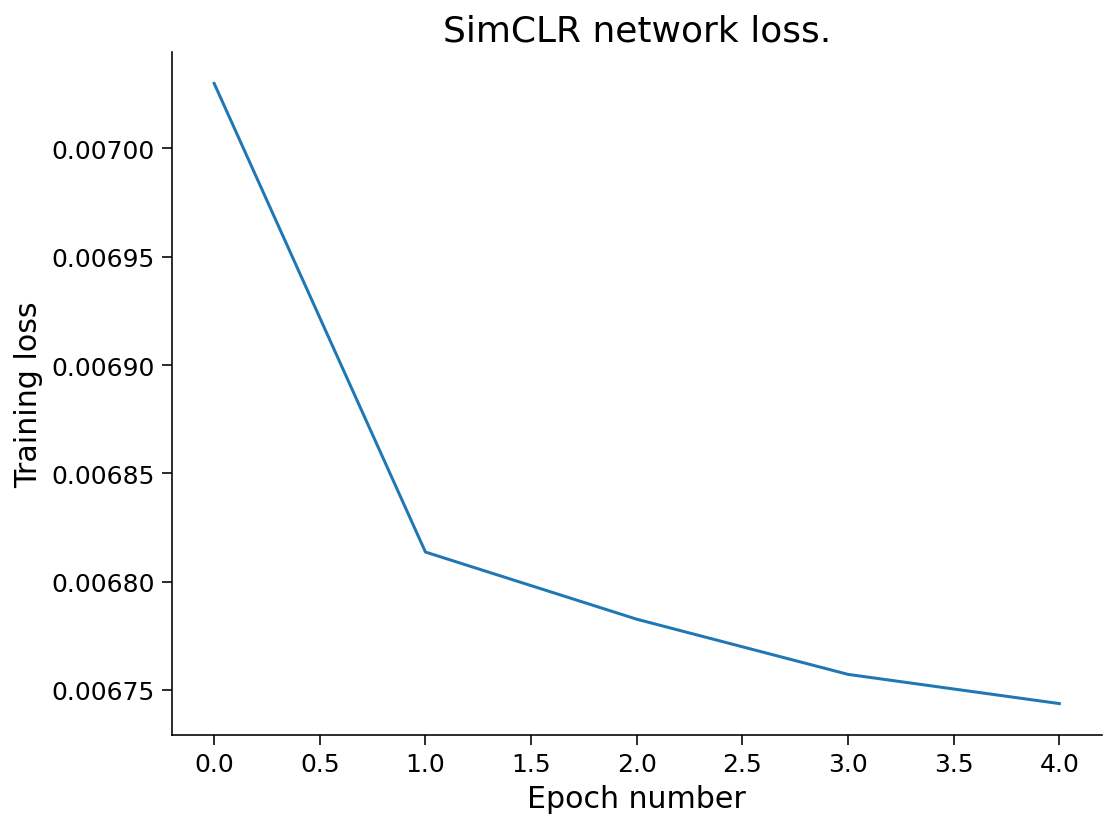

In [15]:
# @markdown ### Solution 6.1.1

# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

def custom_simclr_contrastive_loss(proj_feat1, proj_feat2, temperature=0.5):
    """
    contrastiveLoss(proj_feat1, proj_feat2)
    Returns contrastive loss, given sets of projected features, with positive 
    pairs matched along the batch dimension.
    Required args:
    - proj_feat1 (2D torch Tensor): first set of projected features 
        (batch_size x feat_size)
    - proj_feat2 (2D torch Tensor): second set of projected features 
        (batch_size x feat_size)
      
    Optional args:
    - temperature (float): relaxation temperature. (default: 0.5)
    Returns:
    - loss (float): mean contrastive loss
    """

    device = proj_feat1.device

    if len(proj_feat1) != len(proj_feat2):
        raise ValueError(f"Batch dimension of proj_feat1 ({len(proj_feat1)}) "
            f"and proj_feat2 ({len(proj_feat2)}) should be same")

    batch_size = len(proj_feat1) # N
    z1 = torch.nn.functional.normalize(proj_feat1, dim=1)
    z2 = torch.nn.functional.normalize(proj_feat2, dim=1)

    proj_features = torch.cat([z1, z2], dim=0) # 2N x projected feature dimension
    similarity_mat = torch.nn.functional.cosine_similarity(
        proj_features.unsqueeze(1), proj_features.unsqueeze(0), dim=2
        ) # dim: 2N x 2N
    
    # initialize arrays to identify sets of positive and negative examples
    pos_sample_indicators = \
        torch.roll(torch.eye(2 * batch_size), batch_size, 1)
    neg_sample_indicators = \
        torch.ones(2 * batch_size) - torch.eye(2 * batch_size)

    # EXERCISE: Implement the SimClr loss calculation
    # Calculate the numerator of the Loss expression by selecting the appropriate elements from similarity_mat
    # Use the pos_sample_indicators tensor
    numerator = torch.sum(
        torch.exp(similarity_mat / temperature) * pos_sample_indicators.to(device), 
        dim=1
        )
    
    # Calculate the denominator of the Loss expression by selecting the appropriate elements from similarity_mat
    # Use the neg_sample_indicators tensor
    denominator = torch.sum(
        torch.exp(similarity_mat / temperature) * neg_sample_indicators.to(device), 
        dim=1
        )
    
    if (denominator < 1e-8).any(): # clamp to avoid division by 0
        denominator = torch.clamp(denominator, 1e-8)

    loss = torch.mean(-torch.log(numerator / denominator))
    
    return loss

test_custom_contrastive_loss_fct(custom_simclr_contrastive_loss)

# Train SimCLR for a few epochs
_, test_simclr_loss_array = models.train_simclr(
    encoder=models.EncoderCore(),
    dataset=dSprites_invariance_torchdataset, 
    train_sampler=train_sampler, 
    num_epochs=5, 
    loss_fct=custom_simclr_contrastive_loss
    )

# EXERCISE: Plot SimCLR loss over a few epochs.
fig, ax = plt.subplots()
ax.plot(test_simclr_loss_array)
ax.set_title("SimCLR network loss.")
ax.set_xlabel("Epoch number")
_ = ax.set_ylabel("Training loss")


Given that self-supervised models typically require more training than supervised models, instead of fully pre-training a network here, we will load one that was **pre-trained for 50 epochs**. Again, the **encoder shares the same architecture** as the one used for the supervised, untrained and VAE examples above.

The following code:
*    load the parameters of a SimCLR network pre-trained on the task SimCLR contrastive task using `load.load_encoder()`.

In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# Load SimCLR encoder pre-trained on the contrastive loss
simclr_encoder = load.load_encoder(REPO_PATH, model_type="simclr")

Loading SimCLR encoder from 'neuromatch_ssl_tutorial/checkpoints/simclr_encoder_50ep_bs1000_deg90_trans0-2_scale0-8to1-2_seed2021.pth'.
    => trained for 50 epochs (batch_size of 1000) on the full dSprites subset dataset
with the following random affine transforms:
	degrees=90
	translation=(0.2, 0.2)
	scale=(0.8, 1.2).


### Coding Exercise 6.1.2: Evaluating the classification performance of a logistic regression trained on the representations produced by a SimCLR encoder that was pre-trained using different image transformations.

For the pre-trained SimCLR encoder, as with the VAE encoder, as the encoder parameters have already been trained, they should be kept frozen while the classifier is trained by setting `freeze_features=True`.   

**Exercise:** 
*     Set a number of epochs for which  to train classifier.  
*     Train a classifier, along with the encoder, to classify the input images according to shape, using `models.train_classifier()`.
*     Plot the loss array returned when training the model, and update the number of training epochs, if needed. 

**Hint**: `models.train_classifier()` is introduced in **Interactive Demo 1.2.1**.

In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

#################################################
# EXERCISE: Set a reasonable number of training epochs
num_epochs = None 
#################################################


#################################################
# EXERCISE: Train an encoder and classifier on the images, using models.train_classifier()
print("Training a classifier on the pre-trained SimCLR encoder representations...")
raise NotImplementedError("Exercise: Train a classifer on the pre-trained SimCLR encoder representations.")
#################################################

Training a classifier on the pre-trained SimCLR encoder representations...


NotImplementedError: ignored

Training a classifier on the pre-trained SimCLR encoder representations...



Network performance after 25 classifier training epochs (chance: 33.33%):
    Training accuracy: 92.61%
    Testing accuracy: 92.60%


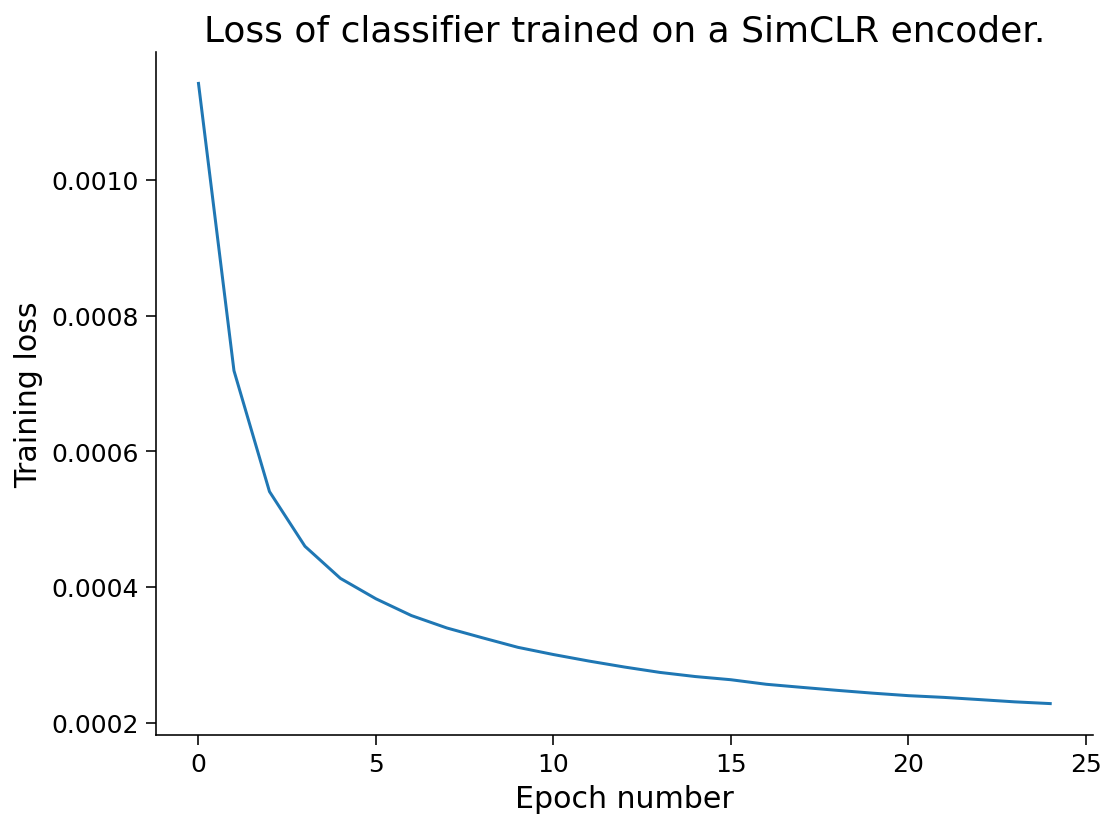

In [ ]:
# @markdown ### Solution 6.1.2

# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# EXERCISE: Set a reasonable number of training epochs
num_epochs = 25

# EXERCISE: Train an encoder and classifier on the images, using models.train_classifier()
print("Training a classifier on the pre-trained SimCLR encoder representations...")
_, simclr_loss_array, _, _ = models.train_classifier(
    encoder=simclr_encoder, 
    dataset=dSprites_torchdataset, 
    train_sampler=train_sampler, 
    test_sampler=test_sampler, 
    freeze_features=True, # keep the encoder frozen while training the classifier
    num_epochs=num_epochs, 
    verbose=True
    )

# EXERCISE: Plot the loss array
fig, ax = plt.subplots()
ax.plot(simclr_loss_array)
ax.set_title("Loss of classifier trained on a SimCLR encoder.")
ax.set_xlabel("Epoch number")
_ = ax.set_ylabel("Training loss")

The network (using the transforms proposed above) performs at 92.60% accuracy on the test dataset, after 25 classifier training epochs. 

---

# Section 7: Self-supervised representations learn invariance.

### **To do:** Add video

### **To do:** Add description

## Section 7.1: The effects of using data transformations on invariance in SimCLR network representations.

We now observe the effects of adding our data transformations on the invariance learned by a pre-trained SimCLR network encoder.  

### Coding Exercise 7.1.1: Visualizing the network encoder RSMs, organized along different latent dimensions.

We will now compare the pre-trained SimCLR encoder network RSM to some of the previously generated encoder RSMs. 

**Exercise:** 
*    Visualize the RSMs for the supervised, VAE and SimCLR network encoders, using `models.plot_model_RSMs()`. 
*    Visualize the RSMs, organized along different latent dimensions (`"posX"`, `"posY"`, `"orientation"` or `"scale"`), and compare the patterns observed for the different encoder networks.

**Hint**: `models.plot_model_RSMs()` is introduced in **Interactive Demo 2.1.1**.

In [ ]:
#################################################
# EXERCISE: Visualize RSMs for the supervised, VAE and SimCLR network encoders.
raise NotImplementedError("Exercise: Plot RSMs.")
#################################################

NotImplementedError: ignored

Plotting RSMs...


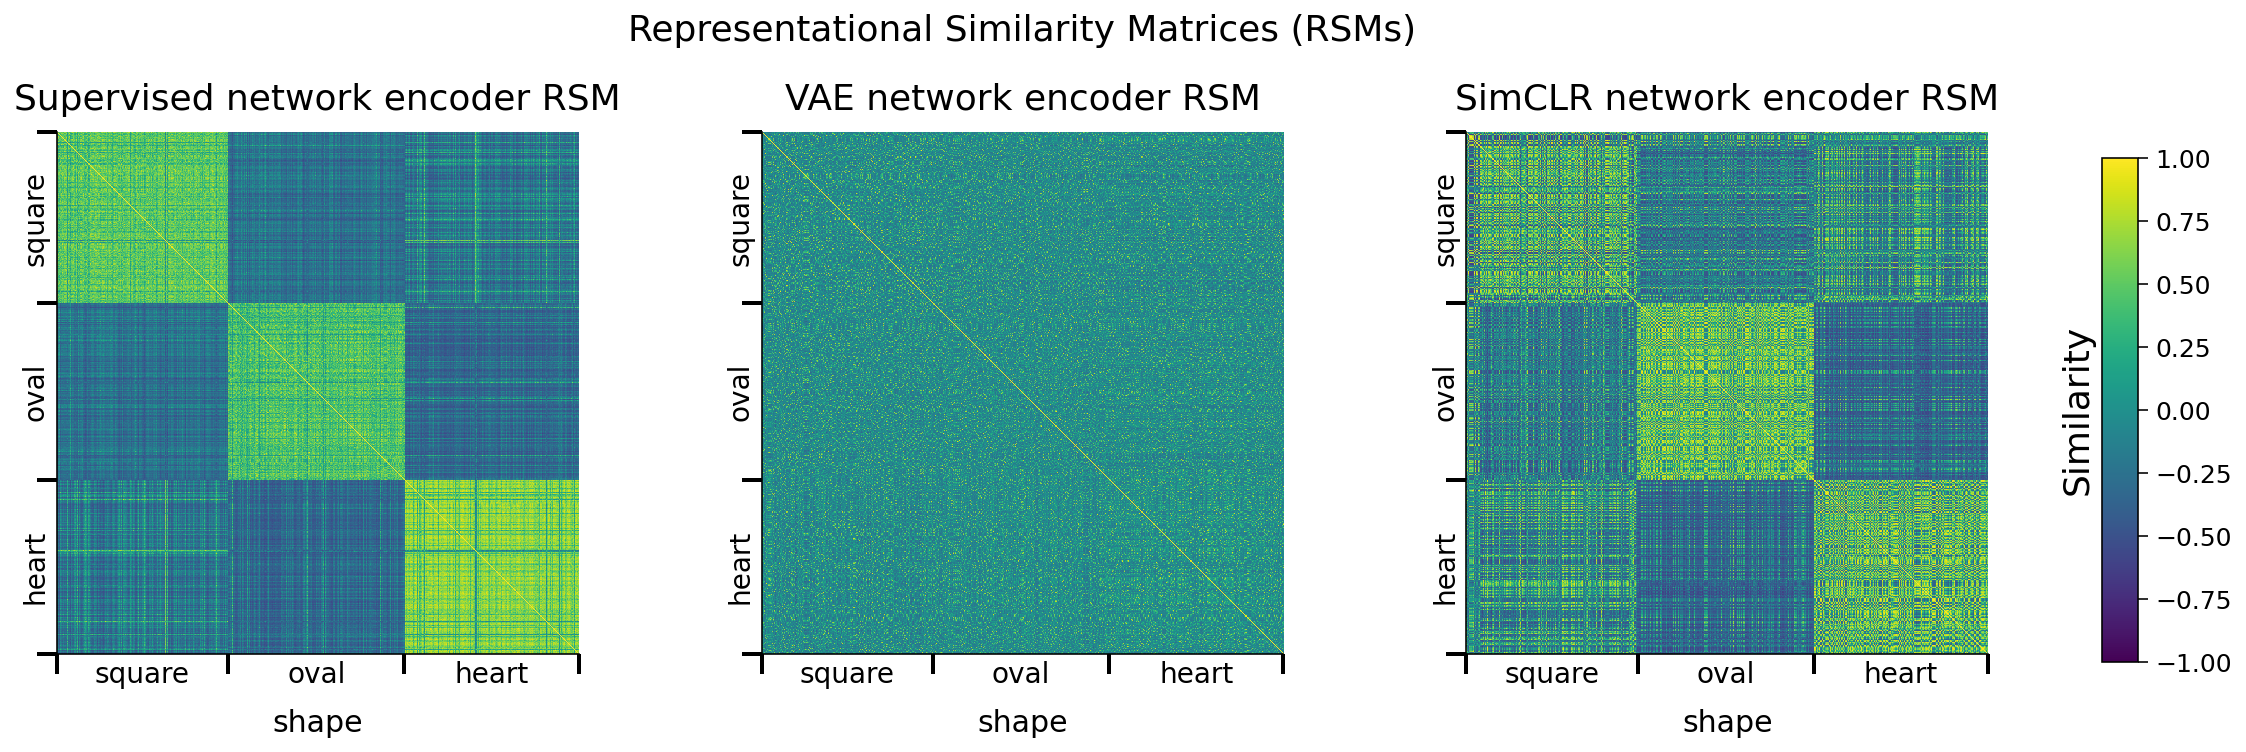

In [ ]:
# @markdown ### Solution 7.1.1

# EXERCISE: Visualize RSMs for the supervised, VAE and SimCLR network encoders.
sorting_latent = "shape"

print("Plotting RSMs...")
_ = models.plot_model_RSMs(
    encoders=[supervised_encoder, vae_encoder, simclr_encoder],
    dataset=dSprites_torchdataset, 
    sampler=test_sampler, # we want to see the representations on the held out test set
    titles=["Supervised network encoder RSM", "VAE network encoder RSM", 
            "SimCLR network encoder RSM"], # plot titles
    sorting_latent=sorting_latent 
    )

### Discussion 7.1.1: What can we conclude about the ability of contrastive models like SimCLR to construct a meaningful representation space?

**A.** How do the pre-trained SimCLR encoder RSMs (sorted along different latent dimensions) compare to the supervised and pre-trained VAE encoder network RSMs?  
**B.**  What explains these different RSMs?  
**C.**  What advantages might some encoders have other others?  
**D.**  How might one modify the SimCLR encoder pre-training, for example, if the downstream task were to predict orientation instead of shape?

### Responses 7.1.1

**A.**  
**B.**  
**C.**  
**D.**  

---

# Section 8: Avoiding representational collapse.


### **To do:** Add video

### **To do:** Add description

## Section 8.1: The effects of reducing the number of negative examples used in the SimCLR contrastive loss.

Typically, a trick used to train neural networks on contrastive losses is to use large batch sizes (here, we use 1,000 examples per batch), and to use the representations of different images in a batch as **each other's negative examples**. So with a batch size of 1,000, each image has one positive paired image (its augmentation), and 1,998 negative paired images (all the other images and their augmentations). This enables the contrastive loss to obtain a good estimate of the full representational distribution.  

To observe the consequences of sampling using fewer negative examples in the contrastive loss, we use a pre-trained SimCLR network again. However, this one was pre-trained with a parameter called `neg_pairs` set to `2`. Under the hood, this parameter affects only the contrastive loss calculation, allowing it to use **only 2 of the total available negative pairs in a batch, for each image.**

The following code:
*    loads the parameters of a SimCLR network pre-trained on the task SimCLR contrastive task, but with only 2 negative pairs used per image in the loss calculation, using `load.load_encoder()`,
*    plots the RSMs of a few network encoders for comparison.

In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# Load SimCLR encoder pre-trained on the contrastive loss
simclr_encoder_neg_pairs = load.load_encoder(
    REPO_PATH, model_type="simclr", neg_pairs=2
    )

Loading SimCLR encoder from 'neuromatch_ssl_tutorial/checkpoints/simclr_encoder_2neg_50ep_bs1000_deg90_trans0-2_scale0-8to1-2_seed2021.pth'.
    => trained for 50 epochs (batch_size of 1000) on the full dSprites subset dataset
with 2 negative pairs per image used in the contrastive loss, and
with the following random affine transforms:
	degrees=90
	translation=(0.2, 0.2)
	scale=(0.8, 1.2).


### Coding Exercise 8.1.1: Visualizing the network encoder RSMs, organized along different latent dimensions.

We will now compare the RSM for the pre-trained SimCLR encoder  trained with **only 2 negative pairs** to the normal pre-trained SimCLR network encoder and the untrained network encoder. To help us compare the representations learned by the normal and modified SimCLR encoders, we will plot a histogram of the values that makes up both RSMs.

**Exercise:** 
*    Visualize the RSMs for the normal SimCLR, 2-neg-pair SimCLR and untrained network encoders, using `models.plot_model_RSMs()`. 
*    Visualize the RSMs, organized along the `shape` latent dimension, and compare the patterns observed for the different encoder networks.
*    Plot a histogram of RSM values for the normal and 2-neg-pair SimCLR network encoders.  

**Hint**: 
*    `models.plot_model_RSMs()` is introduced in **Interactive Demo 2.1.1**.
*    `models.plot_model_RSMs()` returns the **data matrices** calculated for each encoder's RSM, in order.

In [ ]:
#################################################
# EXERCISE: Visualize RSMs for the normal SimCLR, 2-neg-pair SimCLR and untrained network encoders.
raise NotImplementedError("Exercise: Plot RSMs.")
#################################################


#################################################
# EXERCISE: Plot a histogram of RSM values for both encoders.
raise NotImplementedError("Exercise: Plot histogram.")
#################################################

NotImplementedError: ignored

Plotting RSMs...


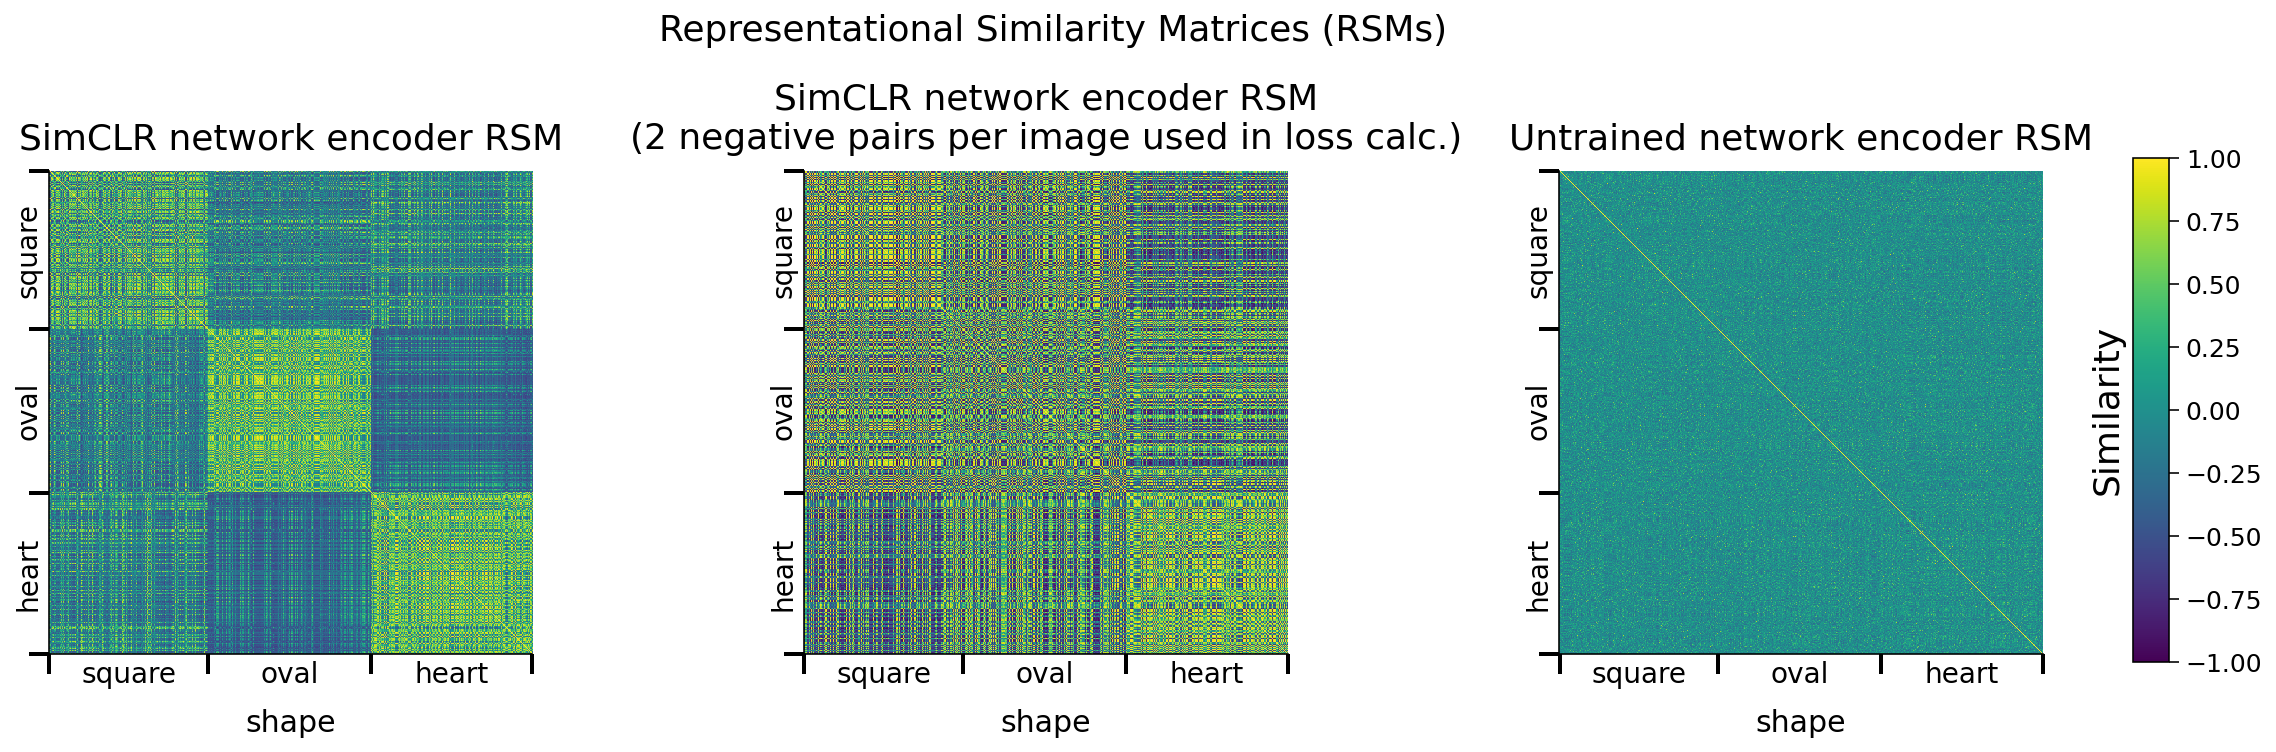

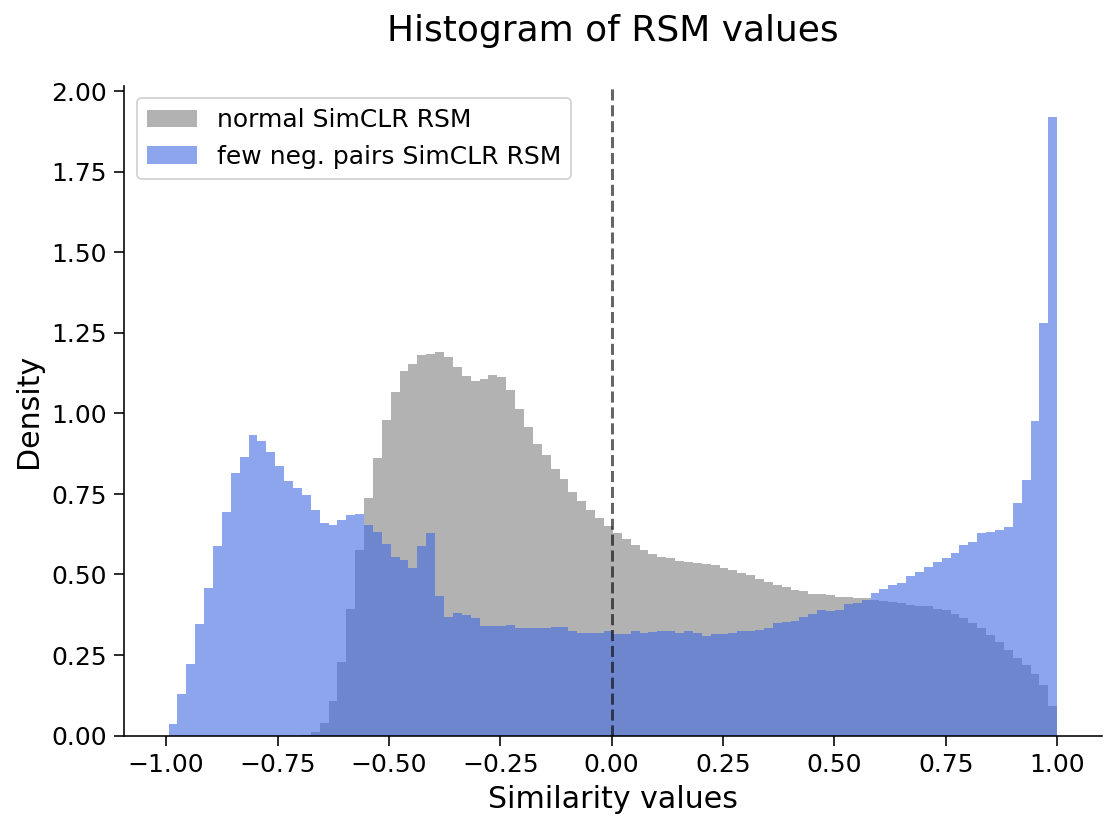

In [ ]:
# @markdown ### Solution 8.1.1

# EXERCISE: Visualize RSMs for the normal SimCLR, 2-neg-pair SimCLR and untrained network encoders.
sorting_latent = "shape" # Exercise: Try sorting by different latent dimensions

print("Plotting RSMs...")
simclr_rsm, simclr_neg_pairs_rsm, untrained_rsm = models.plot_model_RSMs(
    encoders=[simclr_encoder, simclr_encoder_neg_pairs, untrained_encoder],
    dataset=dSprites_torchdataset, 
    sampler=test_sampler, # we want to see the representations on the held out test set
    titles=["SimCLR network encoder RSM", 
            f"SimCLR network encoder RSM\n(2 negative pairs per image used in loss calc.)",
            "Untrained network encoder RSM"], # plot titles
    sorting_latent=sorting_latent 
    )

# EXERCISE: Plot a histogram of RSM values for both encoders.
plot_rsm_histogram(
    [simclr_rsm, simclr_neg_pairs_rsm], 
    colors=["gray", "royalblue"], 
    labels=["normal SimCLR RSM", "few neg. pairs SimCLR RSM"], 
    nbins=100
    )

### Discussion 8.1.1: What can we conclude about the importance of negative pairs in computing the contrastive loss for models like SimCLR?

**A.**  How does changing the number of negative pairs affect the networks' RSMs?  
**B.**  How is the shape classifier likely to perform when the encoder is pre-trained with very few negative pairs?  
**C.**  What, intuitively, is the role of negative pairs in shaping the representational space that a contrastive model learns, and how does this role relate to the role of positive pairs?

### Responses 8.1.1
**A.**  
**B.**  
**C.**  

### Coding Exercise 8.1.2: Evaluating the classification performance of a logistic regression trained on the representations produced by the SimCLR network encoder pre-trained with only a few negative pairs.

For the 2-neg-pair SimCLR encoder, as the encoder parameters have already been trained, they should again be kept frozen while the classifier is trained by setting `freeze_features=True`.   

**Exercise:** 
*     Set a number of epochs for which  to train classifier.  
*     Train a classifier, along with the encoder, to classify the input images according to shape, using `models.train_classifier()`.
*     Plot the loss array returned when training the model, and update the number of training epochs, if needed. 

**Hint**: `models.train_classifier()` is introduced in **Interactive Demo 1.2.1**.

In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

#################################################
# EXERCISE: Set a reasonable number of training epochs
num_epochs = None 
#################################################


#################################################
# EXERCISE: Train an encoder and classifier on the images, using models.train_classifier()
print(f"Training a classifier on the representations learned by the SimCLR "
    f"network encoder pre-trained\nusing only 2 negative pairs per image "
    "for the loss calculation...")
raise NotImplementedError("Exercise: Train a classifer on the pre-trained few negative pairs SimCLR encoder representations.")
#################################################

Training a classifier on the representations learned by the SimCLR network encoder pre-trained
using only 2 negative pairs per image for the loss calculation...


NotImplementedError: ignored

Training a classifier on the representations learned by the SimCLR network encoder pre-trained
using only 2 negative pairs per image for the loss calculation...



Network performance after 50 classifier training epochs (chance: 33.33%):
    Training accuracy: 57.02%
    Testing accuracy: 56.27%


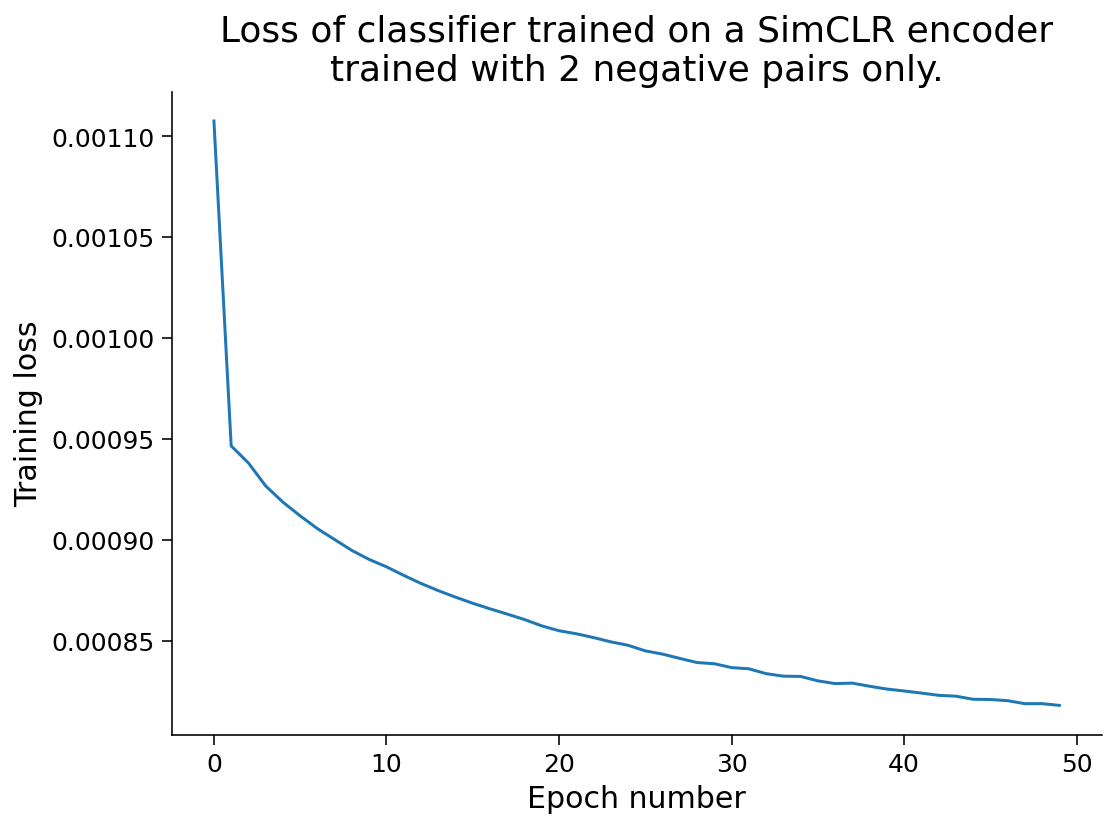

In [ ]:
# @markdown ### Solution 8.1.2

# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

# EXERCISE: Set a reasonable number of training epochs
num_epochs = 50

# EXERCISE: Train an encoder and classifier on the images, using models.train_classifier()
print(f"Training a classifier on the representations learned by the SimCLR "
    f"network encoder pre-trained\nusing only 2 negative pairs per image "
    "for the loss calculation...")
_, simclr_neg_pairs_loss_array, _, _ = models.train_classifier(
    encoder=simclr_encoder_neg_pairs, 
    dataset=dSprites_torchdataset, 
    train_sampler=train_sampler, 
    test_sampler=test_sampler, 
    freeze_features=True, # keep the encoder frozen while training the classifier
    num_epochs=num_epochs, 
    verbose=True
    )

# EXERCISE: Plot the loss array
fig, ax = plt.subplots()
ax.plot(simclr_neg_pairs_loss_array)
ax.set_title(("Loss of classifier trained on a SimCLR encoder\n"
  "trained with 2 negative pairs only."))
ax.set_xlabel("Epoch number")
_ = ax.set_ylabel("Training loss")

After dropping the number of negative pairs used per image in pre-training a SimCLR encoder, classification accuracy drops to 56.27% on the test dataset, after 50 classifier training epochs. 

---

# Section 9: Good representations enable few-shot learning.


### **To do:** Add video

### **To do:** Add description

## Section 9.1: The benefits of pre-training an encoder network in a few-short learning scenario, i.e., when only few labelled examples are available.

The toy dataset we have been using, **dSprites**, is thoroughly labelled along 5 different dimensions. However, this is not the case for many datasets. Some very large datasets may have few if any labels.

One of our last steps is to examine how each of our models perform in such a case when only few labelled images are available for training. In this scenario, we will train classifiers on different fractions of the training data (between 0.01 and 1.0), and see how they perform on the test set. 

For the difference types of encoder, this means:
*    **Supervised encoder:** As the supervised encoder can only be trained with labels, we will start from untrained encoders and train them end-to-end on the classification task with the fraction of labelled images allowed.  
_N.B.: Given that that network is trained end-to-end, we will train it for more epochs, and mark it with "\*" in the graphs._
*    **Untrained encoder:** By definition, the untrained encoder is untrained.
*    **VAE encoder**: As a generative model can be pre-trained on unlabelled data, we will use the VAE encoder pre-trained on the reconstruction task using the full dataset, before training the classifier layer with the fraction of labelled images allowed.
*    **SimCLR encoder**: As an SSL model can be pre-trained on unlabelled data, we will use the SimCLR encoder pre-trained on the contrastive task using the full dataset, before training the classifier layer with the fraction of labelled images allowed.

_N.B.: The numbers of epochs are specified below for when the **full training dataset** is used. For each fraction of the dataset a classifier is trained on, the **number of training epochs is scaled up** to compensate for the drop in number of training examples. For example, if we specify 10 epochs for a model, the 0.1 fraction labelled classifier will be trained over ~30 epochs. Also, we use **slightly fewer epochs** than above, here, in the interest of time._

### Interactive Demo 9.1.1: Training classifiers on different encoders, using only a fraction of the full labelled dataset.

In this demo, we select a few fractions (5 or 6) of the full labelled dataset with which to train classifiers.

**Interactive Demo:** Set `labelled_fractions` argument to a list of fractions (5 or 6 values between 0.01 and 1.0) with which to train classifiers for each encoder.

ValueError: ignored

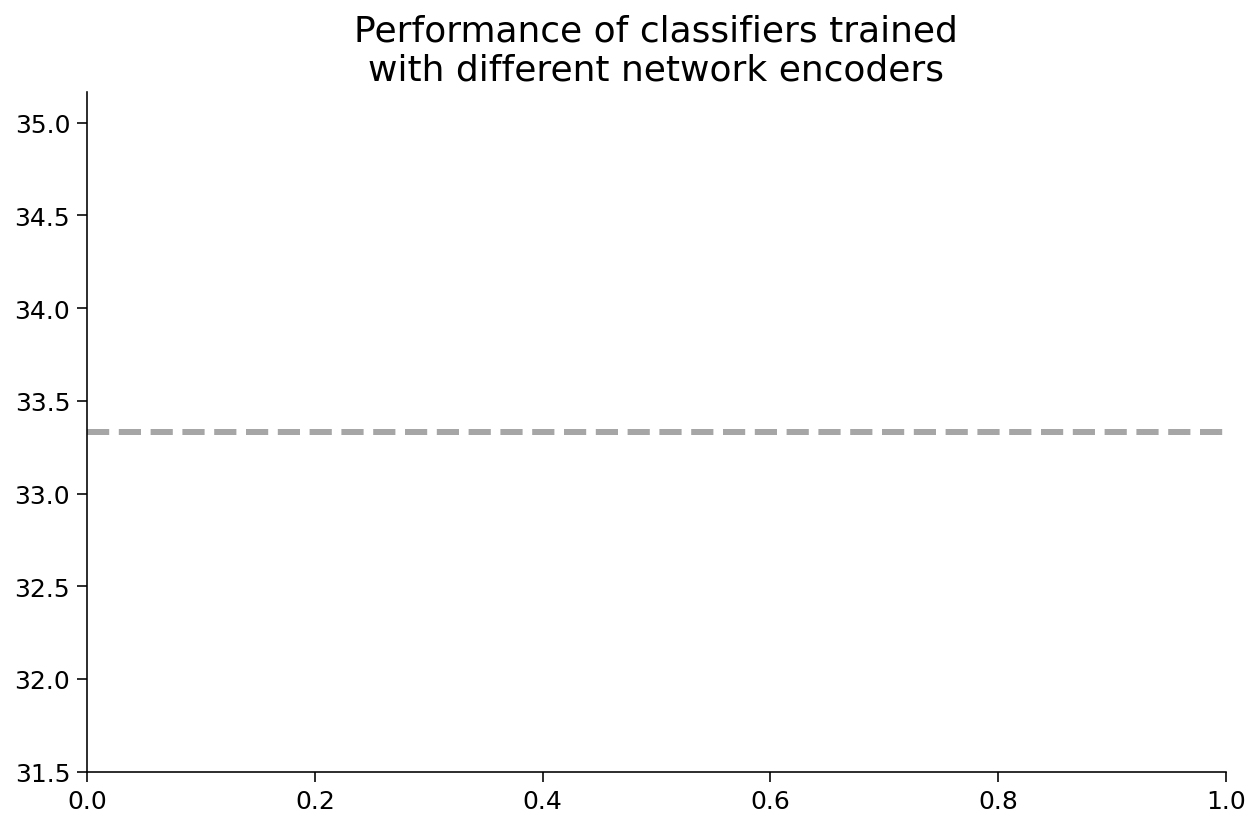

In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

new_supervised_encoder = models.EncoderCore() # new, untrained supervised encoder

_ = models.train_encoder_clfs_by_fraction_labelled(
    encoders=[new_supervised_encoder, untrained_encoder, vae_encoder, simclr_encoder], 
    dataset=dSprites_torchdataset,
    train_sampler=train_sampler, 
    test_sampler=test_sampler, 
    labelled_fractions=[], # DEMO: select fractions to run
    num_epochs=[20, 8, 8, 8], # train the supervised network (end-to-end) for more epochs
    freeze_features=[False, True, True, True], # only train new supervised network end-to-end
    subset_seed=SEED, 
    encoder_labels=["supervised", "untrained", "VAE", "SimCLR"], 
    title="Performance of classifiers trained\nwith different network encoders", 
    verbose=True
)

### Discussion 9.1.1: What can we conclude the advantages and disadvantages of the different encoder network types under different conditions?

**A.** Which models are most and least affected by how much labelled data is available?

### Responses 9.1.1
**A.**  

---

# Section 10: Ethical considerations for self-supervised learning from biased datasets.


### **To do:** Add video

### **To do:** Add description

## Section 10.1: The consequences of training models on biased datasets.

If a model is trained on a biased dataset, it is likely to learn a representational encoding that reproduces these biases, impairing its ability to generalize properly and increasing the likelihood that it will propagate these biases forward.  

Here, we investigate the effects of training the models on a biased subset of the training dataset. Specifically, we introduce a `train_sampler_biased`, a training dataset sampler that only samples:
*    **squares**, if they are centered on the **lefthand** side of an image **(posX: 0 to 0.3)**,
*    **ovals**, if they are centered in the **center** of an image **(posX: 0.35 to 0.65)**, 
*    **hearts**, if they are centered on the **righthand** side of am image **(posX: 0.7 to 1.0)**.

This sampling bias introduces a correlation between `shape` and `posX` that does not exist in the original dataset.

We then train each model as above on the dataset, and observe their performance when tested on an unbiased dataset.

*N.B.: This biased sampling also significantly reduces the size of the training dataset available (approximately 6x). Thus, it would not be fair to compare our results here to those obtained previously in the tutorial, when we were using the full dataset. For this reason, **as a control, we will also separately train the models with `train_sampler_bias_ctrl`**, a training dataset sampler that does not share the same sampling bias as `train_sampler_biased`, but can only sample as many samples as `train_sampler_biased` can.*

In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

bias_type = "shape_posX_spaced" # name of this bias

# initialize a biased training sampler and an unbiased test sampler
train_sampler_biased, test_sampler_for_biased = data.train_test_split_idx(
    dSprites_torchdataset, 
    fraction_train=0.95, # 95:5 split to partially compensate for loss of training examples due to bias
    randst=SEED,
    train_bias=bias_type
    )

# initialize a control, unbiased training sampler and an unbiased test sampler
train_sampler_bias_ctrl, test_sampler_for_bias_ctrl = data.train_test_split_idx(
    dSprites_torchdataset, 
    fraction_train=0.95, 
    randst=SEED,
    train_bias=bias_type,
    control = True
    )

print(f"Biased dataset: {len(train_sampler_biased)} training, "
  f"{len(test_sampler_for_biased)} test images")
print(f"Bias control dataset: {len(train_sampler_bias_ctrl)} training, "
  f"{len(test_sampler_for_bias_ctrl)} test images")

Biased dataset: 5808 training, 1000 test images
Bias control dataset: 5808 training, 1000 test images


We plot some images sampled with `train_sampler_biased` to observe the pattern described above where `shape` and `posX` are now correlated.

Plotting sample images from the biased training dataset.



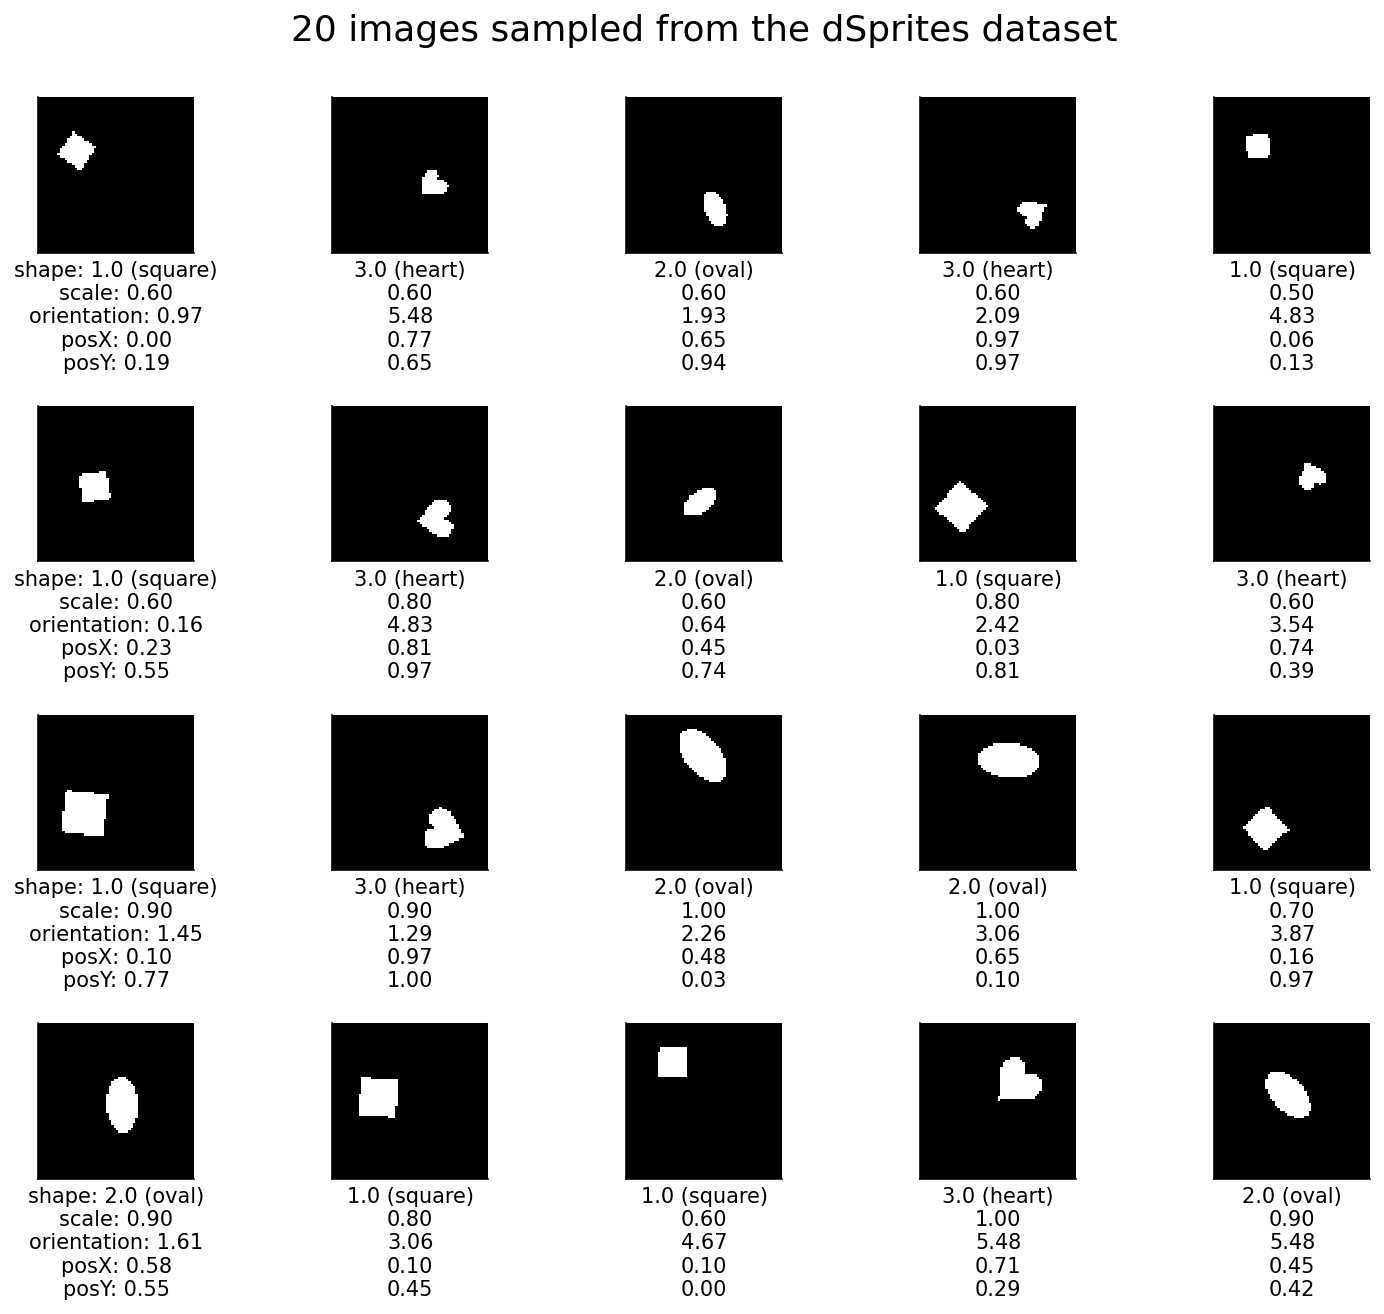

In [ ]:
print("Plotting sample images from the biased training dataset.\n")
dSprites.show_images(indices=train_sampler_biased.indices[:20], randst=SEED)

We also plot some images sampled with `train_sampler_bias_ctrl` to verify visually that this biased pattern does not appear in the control dataset.

Plotting sample images from the bias control training dataset.



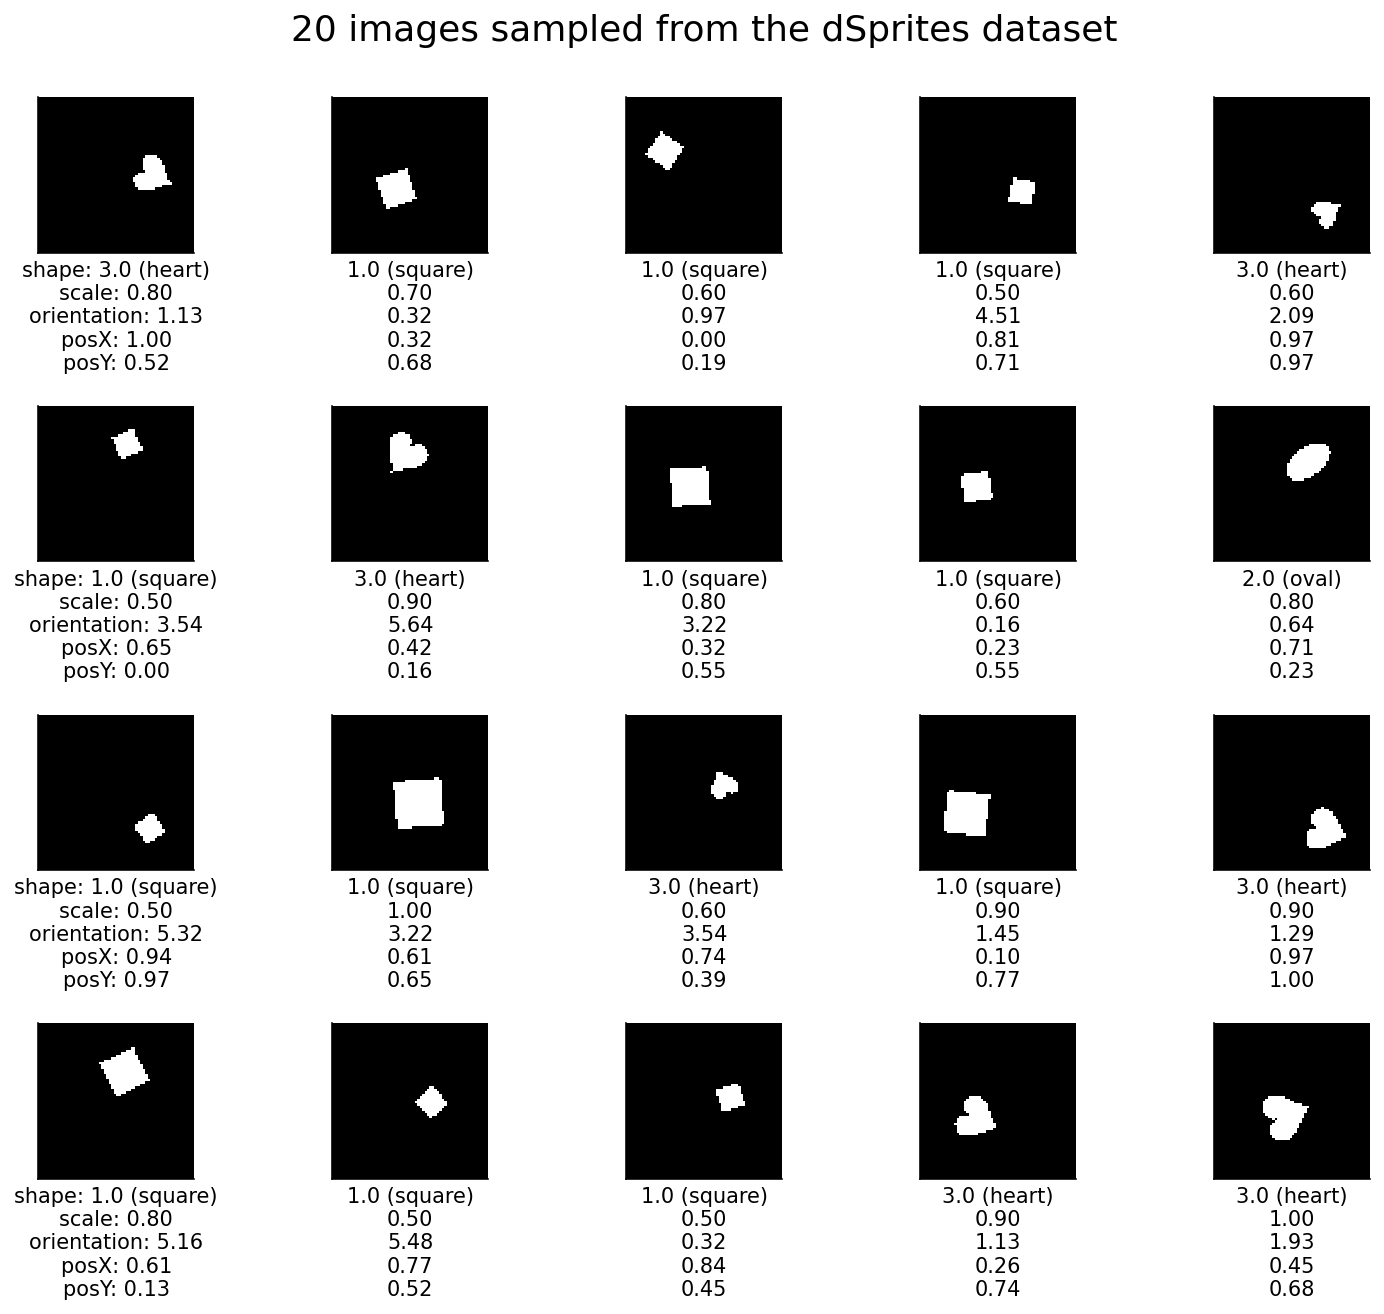

In [ ]:
print("Plotting sample images from the bias control training dataset.\n")
dSprites.show_images(indices=train_sampler_bias_ctrl.indices[:20], randst=SEED)

In [ ]:
# @markdown Function to run full training procedure (from initializing and 
# @markdown pretraining encoders to training classifiers):  
# @markdown `full_training_procedure(train_sampler, test_sampler)`

def full_training_procedure(train_sampler, test_sampler, title=None, 
                            dataset_type="biased", verbose=True):

    if dataset_type not in ["biased", "bias_ctrl"]:
        raise ValueError("Expected model_type to be 'biased' or 'bias_ctrl', "
          f"but found {model_type}.")

    supervised_encoder = models.EncoderCore()
    untrained_encoder = models.EncoderCore()
    
    # Load pre-trained VAE encoder
    vae_encoder = load.load_encoder(
        REPO_PATH, model_type="vae", dataset_type=dataset_type,
        verbose=verbose
        )

    # Load pre-trained SimCLR encoder
    simclr_encoder = load.load_encoder(
        REPO_PATH, model_type="simclr", dataset_type=dataset_type,
        verbose=verbose
        )

    encoders = [supervised_encoder, untrained_encoder, vae_encoder, simclr_encoder]
    freeze_features = [False, True, True, True]
    encoder_labels = ["supervised", "untrained", "VAE", "SimCLR"]

    num_clf_epochs = [80, 30, 30, 30]
    print(f"\nTraining supervised encoder and classifier for {num_clf_epochs[0]}+ "
      f"epochs, and all other classifiers for {num_clf_epochs[1]}+ epochs each.")
    _ = models.train_encoder_clfs_by_fraction_labelled(
        encoders=encoders, 
        dataset=dSprites_torchdataset,
        train_sampler=train_sampler, 
        test_sampler=test_sampler, 
        num_epochs=num_clf_epochs,
        freeze_features=freeze_features,
        subset_seed=SEED, 
        encoder_labels=encoder_labels,
        title=title, 
        verbose=verbose
        )

We now run the same analyses as in **Section 9**, but with our **biased training data sampler** (and unbiased control sampler) to observe how the different models perform. Because the dataset is much smaller, we increase the number of pre-trained and training epochs for the encoders and classifiers.

Let us start with our **unbiased control sampler**, to get a sense of the classification performance levels we should expect with a dataset this size.

Training all models using the control, unbiased training dataset

Loading VAE encoder from 'neuromatch_ssl_tutorial/checkpoints/vae_encoder_bias_ctrl_450ep_bs500_seed2021.pth'.
    => trained for 450 epochs (batch_size of 500) on the bias_ctrl dSprites subset dataset.
Loading SimCLR encoder from 'neuromatch_ssl_tutorial/checkpoints/simclr_encoder_bias_ctrl_125ep_bs1000_deg90_trans0-2_scale0-8to1-2_seed2021.pth'.
    => trained for 125 epochs (batch_size of 1000) on the bias_ctrl dSprites subset dataset
with the following random affine transforms:
	degrees=90
	translation=(0.2, 0.2)
	scale=(0.8, 1.2).

Training supervised encoder and classifier for 80+ epochs, and all other classifiers for 30+ epochs each.
Using the following default labelled fraction values: 0.05, 0.1, 0.2, 0.4, 0.75, 1.0

Supervised encoder: training classifiers and encoders*...



Untrained encoder: training classifiers...



VAE encoder: training classifiers...



SimCLR encoder: training classifiers...


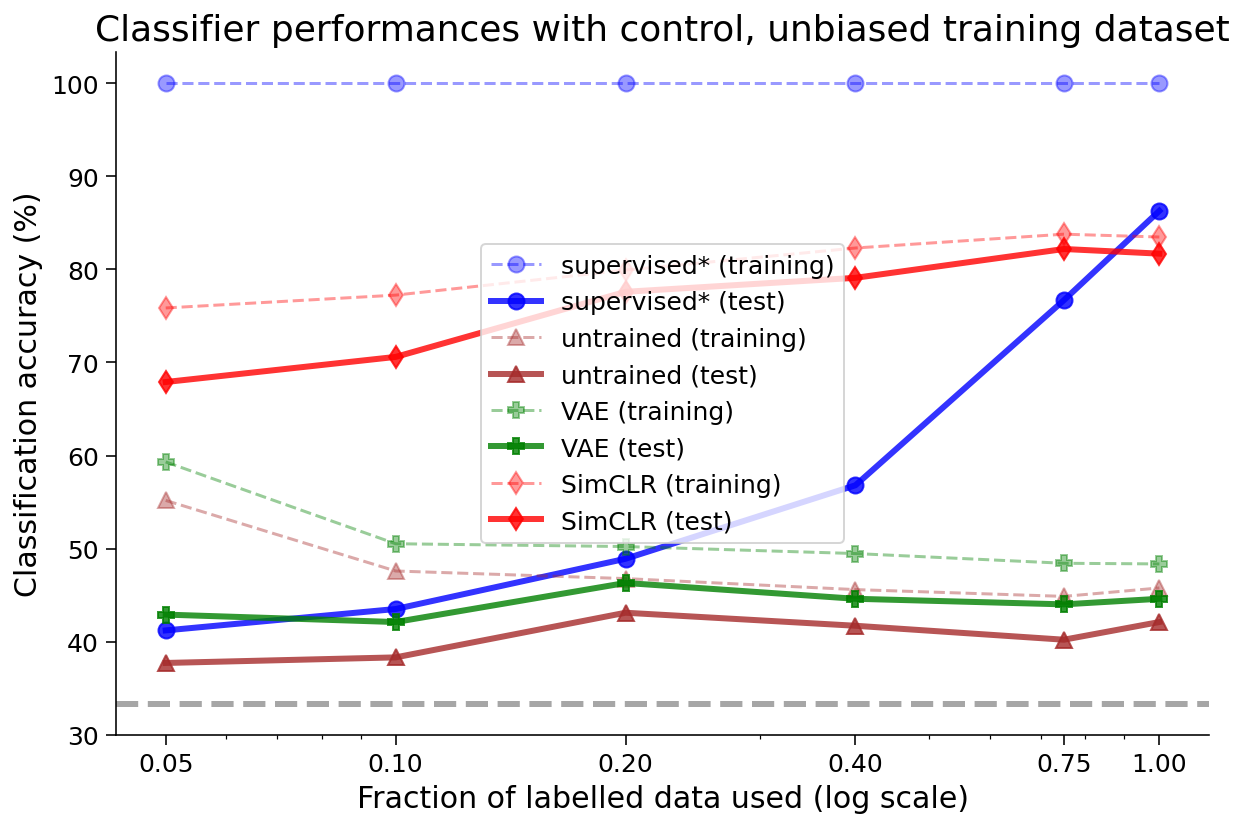

In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

print("Training all models using the control, unbiased training dataset\n")
full_training_procedure(
    train_sampler_bias_ctrl, test_sampler_for_bias_ctrl, 
    title="Classifier performances with control, unbiased training dataset",
    dataset_type="bias_ctrl" # for loading correct pre-trained networks
    )

A similar pattern is observed here as with the full dataset, though notably most performances are a bit weaker, likely due to us (A) using a smaller training dataset, and (B) training and pre-training for fewer iterations, considering to the dataset size, for time-efficiency reasons.

Using the same parameters, we now repeat the analysis with the **biased** training data sampler.

Training all models using the biased training dataset

Loading VAE encoder from 'neuromatch_ssl_tutorial/checkpoints/vae_encoder_biased_450ep_bs500_seed2021.pth'.
    => trained for 450 epochs (batch_size of 500) on the biased dSprites subset dataset.
Loading SimCLR encoder from 'neuromatch_ssl_tutorial/checkpoints/simclr_encoder_biased_125ep_bs1000_deg90_trans0-2_scale0-8to1-2_seed2021.pth'.
    => trained for 125 epochs (batch_size of 1000) on the biased dSprites subset dataset
with the following random affine transforms:
	degrees=90
	translation=(0.2, 0.2)
	scale=(0.8, 1.2).

Training supervised encoder and classifier for 80+ epochs, and all other classifiers for 30+ epochs each.
Using the following default labelled fraction values: 0.05, 0.1, 0.2, 0.4, 0.75, 1.0

Supervised encoder: training classifiers and encoders*...



Untrained encoder: training classifiers...



VAE encoder: training classifiers...



SimCLR encoder: training classifiers...


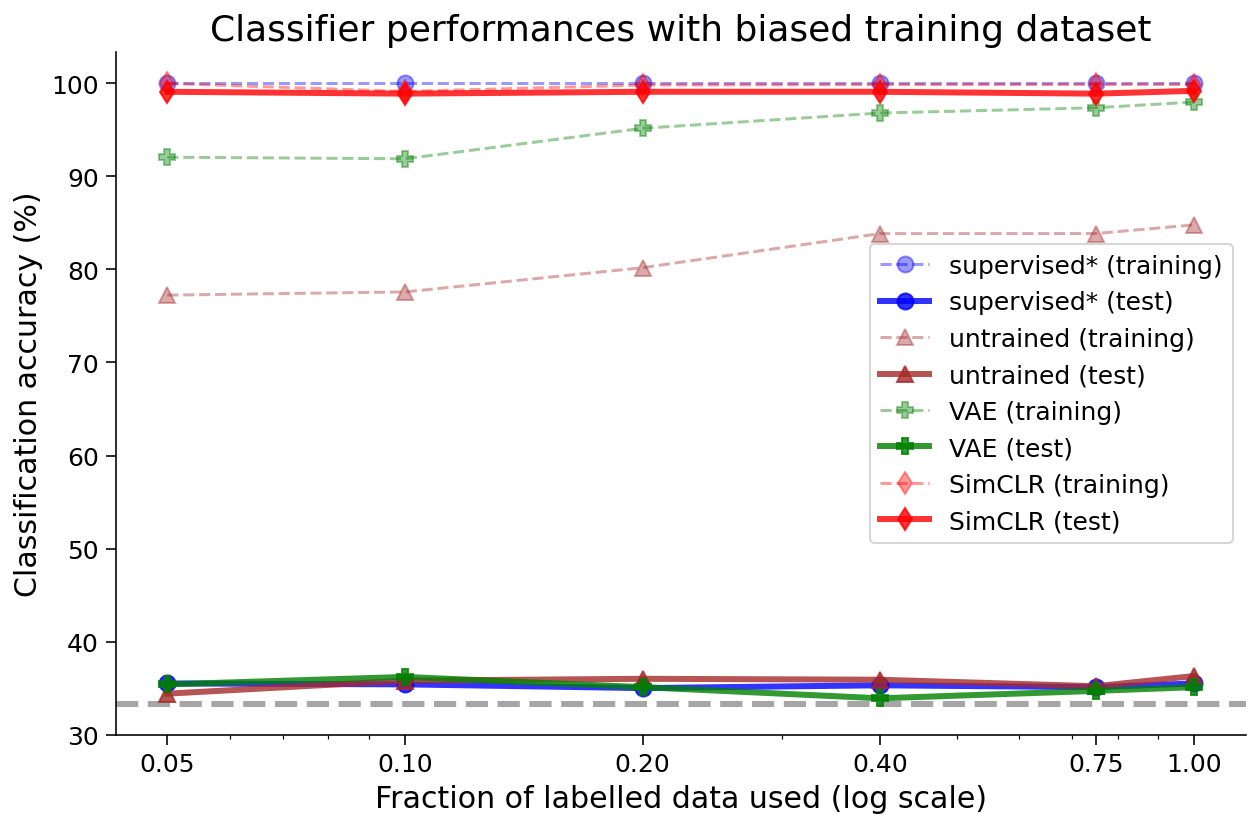

In [ ]:
# call this before any dataset/network initializing or training, 
# to ensure reproducibility
seed_processes(SEED)

print("Training all models using the biased training dataset\n")
full_training_procedure(
    train_sampler_biased, test_sampler_for_biased, 
    title="Classifier performances with biased training dataset",
    dataset_type="biased" # for loading correct pre-trained networks
    )

Interestingly, the SimCLR network encoder is not only the only network to perform well, it even outperforms its control performance (which uses the same test dataset), at least with this particular dataset and biasing.

### Discussion 10.1.1: How do different models cope with a biased training dataset?

**A.** Which models are most and least affected by the biased training dataset?  
**B.** Which types of images in the test set are most likely causing the observed drop in performance?  
**C.** Why might certain models be more robust to the bias introduced here than others?  
**D.** What are some methods we can employ to help mitigate the negative effects of biases in our training sets on our ability to learn good data representations with our models?

### Responses 10.1.1

**A.**   
**B.**   
**C.**   
**D.** 

### Discussion 10.1.2: How do these principles apply more generally?

We have seen now how self-supervised learning (SSL) can improve a network's ability to learn good representations of data. For the purposes of this tutorial, we presented examples with a simplified dataset: the dSprites dataset, where we know: 
(1) the latent dimensions for all images,  
(2) the joint probability distribution across latent dimensions for the full dataset, and  
(3) the precise nature of the bias introduced into our biased dataset **(Section 10)**. 

In real-world applications, with more complex or difficult datasets,   
**A.** What principles can we draw on to successfully apply SSL to learn good data representations?  
**B.** What challenges might we face, compared to applying SSL to dSprites?

### Responses 10.1.2

**A.**   
**B.**   